# PySpark 数据分析与预处理
本 Notebook 对合成的 10G/30G 用户数据集进行探索性分析、预处理和高价值用户识别。

In [1]:
# 导入库与初始化 SparkSession
import os
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # 导入字体管理器

# 导入 PySpark 相关库
from pyspark.sql import SparkSession
from pyspark.sql import functions as F # F 包含了常用的 Spark SQL 函数
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, ArrayType, MapType # 用于定义数据结构
from pyspark.sql.window import Window # 用于 RFM 打分

# --- 初始化 SparkSession ---
print("--- 正在初始化 Spark Session ---")
start_time_init = time.time()

# 配置 Spark Session
# spark.driver.memory 需要根据你的电脑可用内存调整 (例如: "4g", "8g", "16g")
# spark.executor.memory 也需要调整，之前发现在local[32]时，128g可用
# spark.driver.maxResultSize 限制驱动程序能收集的最大结果大小
# local[*] 表示使用本机上所有可用的 CPU 核心 (之前发现可能OOM，改为 local[32])
try:
    spark = (
        SparkSession.builder
        .appName("PySpark_EDA_Preprocessing")
        .master("local[32]")  # <-- !!! 限制核心数以防止 OOM !!!
        .config("spark.driver.memory", "16g")
        .config("spark.executor.memory", "128g")
        .config("spark.driver.maxResultSize", "8g")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .config("spark.sql.parquet.enableVectorizedReader", "true")
        .config("spark.sql.legacy.parquet.datetimeRebaseModeInRead", "CORRECTED")
        .config("spark.ui.showConsoleProgress", "false")
        .getOrCreate()
    )

    sc = spark.sparkContext # 获取 SparkContext
    print(f"Spark Session 初始化成功。")
    print(f"Spark 版本: {spark.version}")
    print(f"Spark 主节点 (Master): {sc.master}")
    print(f"Spark 应用名称 (App Name): {sc.appName}")
    # Spark UI 通常在 http://localhost:4040 (当 Session 运行时可以访问)

except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"初始化 Spark Session 时出错: {e}")
    print(f"请确保 Java (推荐 JRE 8 或 11) 已正确安装并配置。")
    print(f"可能需要设置 JAVA_HOME 环境变量。")
    print(f"停止执行。")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit() # 如果是脚本，则退出


end_time_init = time.time()
init_duration = end_time_init - start_time_init
print(f"初始化耗时: {init_duration:.2f} 秒")
if 'processing_times' not in locals(): processing_times = {}
processing_times['init'] = init_duration # 记录初始化时间

--- 正在初始化 Spark Session ---


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 05:14:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session 初始化成功。
Spark 版本: 3.5.5
Spark 主节点 (Master): local[32]
Spark 应用名称 (App Name): PySpark_EDA_Preprocessing
初始化耗时: 3.12 秒


In [2]:
# 配置 - 数据路径和字体设置准备
# --- 定义数据文件路径 ---
data_dir_10g = './10G_data_new/'
data_dir_30g = './30G_data_new/'

# --- 选择要处理的数据集 ---
# 先从 10G 开始，之后可以修改这里运行 30G
current_data_dir = data_dir_10g
# current_data_dir = data_dir_30g

# --- 定义输出文件的前缀 (用于保存结果) ---
# 从目录路径自动获取数据集名称作为前缀
output_prefix = os.path.basename(os.path.normpath(current_data_dir))

print(f"选择的数据目录: {current_data_dir}")
print(f"输出文件前缀: {output_prefix}_")

# --- 准备字体设置 (需要在绘图前找到字体路径) ---
print("\n--- 配置 Matplotlib 中文字体 ---")
font_names = ['SimHei', 'WenQuanYi Zen Hei', 'WenQuanYi Micro Hei', 'STHeiti', 'Heiti TC', 'Heiti SC', 'Noto Sans CJK SC']
found_font_path = None
found_font_name = None
font_setting_successful = False # 初始化标记

font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print("正在查找可用的中文字体...")
for font_path in font_paths:
    try:
        font_prop = fm.FontProperties(fname=font_path)
        font_name = font_prop.get_name()
        if font_name in font_names:
            if os.path.exists(font_path):
                 print(f"找到可用字体: {font_name} at {font_path}")
                 found_font_path = font_path
                 found_font_name = font_name
                 font_setting_successful = True # 标记成功找到
                 break
    except RuntimeError: continue
    except Exception as e: continue

if font_setting_successful:
     print(f"将使用字体: {found_font_name} (路径: {found_font_path})")
     # 获取字体属性对象，供后续绘图使用
     try: font_prop = fm.FontProperties(fname=found_font_path)
     except Exception as e: print(f"创建字体属性对象失败: {e}"); font_prop = None; font_setting_successful = False
else:
    print("警告: 未在系统中找到推荐的常见中文字体。请安装字体并清除 matplotlib 缓存后重试。")
    font_prop = None # 确保 font_prop 不存在

选择的数据目录: ./10G_data_new/
输出文件前缀: 10G_data_new_

--- 配置 Matplotlib 中文字体 ---
正在查找可用的中文字体...
找到可用字体: WenQuanYi Zen Hei at /usr/share/fonts/truetype/wqy/wqy-zenhei.ttc
将使用字体: WenQuanYi Zen Hei (路径: /usr/share/fonts/truetype/wqy/wqy-zenhei.ttc)


## 1. 数据加载与初步探索

In [3]:
# 加载数据
# --- 加载 Parquet 数据 ---
print(f"\n--- 正在从以下路径加载 Parquet 数据: {current_data_dir} ---")
start_time_load = time.time()

df = None # 初始化 DataFrame 变量
load_successful = False
total_rows = 0

try:
    # Spark 会自动发现并读取目录下的所有 Parquet 文件
    df = spark.read.parquet(current_data_dir)

    # 触发一个操作 (Action)，比如 count()，来实际验证数据加载并获取行数
    print("正在通过计算行数来验证数据加载...")
    total_rows = df.count() # count() 会强制 Spark 读取元数据或部分数据

    print(f"数据加载成功。")
    print(f"总行数: {total_rows}")
    load_successful = True

except Exception as e:
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"使用 Spark 加载 Parquet 数据时出错: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    # spark.stop() # 可以考虑在严重错误时停止 Spark

end_time_load = time.time()
loading_duration = end_time_load - start_time_load

if load_successful:
    print(f"数据加载耗时: {loading_duration:.2f} 秒")
    # 记录加载时间，用于报告
    if 'loading_times' not in locals(): loading_times = {}
    loading_times[output_prefix] = loading_duration
else:
    print(f"数据加载失败，耗时 {loading_duration:.2f} 秒。")
    if 'loading_times' not in locals(): loading_times = {}
    loading_times[output_prefix] = -1.0 # 用 -1 表示失败

# 只有加载成功时才显示 DataFrame 信息
if load_successful:
    print("\nDataFrame 已赋值给变量 'df'")
else:
    df = None # 确保加载失败时 df 为 None


--- 正在从以下路径加载 Parquet 数据: ./10G_data_new/ ---


25/04/20 05:14:19 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.
25/04/20 05:14:19 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.
25/04/20 05:14:19 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.


正在通过计算行数来验证数据加载...
数据加载成功。
总行数: 45000000
数据加载耗时: 5.01 秒

DataFrame 已赋值给变量 'df'


In [4]:
# 初步探索 - Schema 和样例数据
# --- 初步探索 ---

if df is not None: # 只有 df 存在时才执行
    print("\n--- DataFrame 结构 (Schema) ---")
    df.printSchema() # 打印列名和数据类型

    print("\n--- 样例数据 (前 5 行) ---")
    # 显示前 5 行，truncate=False 防止列内容被截断，方便查看完整内容
    try:
        df.show(5, truncate=False)
    except Exception as e:
        print(f"显示 DataFrame 样例时出错: {e}")

    # 可选：获取分区数 (了解 Spark 如何并行处理)
    num_partitions = df.rdd.getNumPartitions()
    print(f"\nSpark 分区数: {num_partitions}")

else:
    print("由于数据加载错误，DataFrame 'df' 不可用。")


--- DataFrame 结构 (Schema) ---
root
 |-- id: long (nullable = true)
 |-- last_login: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- purchase_history: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- login_history: string (nullable = true)


--- 样例数据 (前 5 行) ---
+---+-------------------------+----------+--------+--------------------+---+---------+------+--------+-------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+--------

 ## 2. 数据质量评估与预处理

In [5]:
# --- 数据质量评估：检查缺失值 ---

missing_values_summary = {} # 用于存储最终报告

if df is not None:
    print("\n--- 检查缺失值 (Null / NaN) ---")
    start_time_missing = time.time()

    # 计算每列的 null 或 NaN 值的数量（仅对 DOUBLE/FLOAT 类型用 isnan）
    missing_counts = df.select([
        F.count(
            F.when(
                F.col(c).isNull() | (
                    (isinstance(df.schema[c].dataType, DoubleType) or str(df.schema[c].dataType) == "FloatType")
                    and F.isnan(F.col(c))
                ),
                c
            )
        ).alias(c)
        if isinstance(df.schema[c].dataType, DoubleType) or str(df.schema[c].dataType) == "FloatType"
        else F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]).first().asDict()

    print(f"基于 {total_rows} 行数据的缺失值统计:")
    has_missing = False
    for col_name, count in missing_counts.items():
        if count > 0:
            percentage = (count / total_rows) * 100
            print(f" - 列 '{col_name}': {count} 个缺失值 ({percentage:.4f}%)")
            missing_values_summary[col_name] = {'count': count, 'percentage': percentage}
            has_missing = True

    if not has_missing:
        print("数据集中未发现缺失值 (Null or NaN)。")
        missing_values_summary['overall'] = 'No missing values found.'

    end_time_missing = time.time()
    missing_check_duration = end_time_missing - start_time_missing
    print(f"\n缺失值检查耗时: {missing_check_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_missing_check'] = missing_check_duration

else:
    print("DataFrame 'df' 不可用。")


--- 检查缺失值 (Null / NaN) ---
基于 45000000 行数据的缺失值统计:
数据集中未发现缺失值 (Null or NaN)。

缺失值检查耗时: 11.48 秒


In [6]:
# --- 数据质量评估：检查重复行 ---

duplicate_count = 0 # 初始化重复计数
duplicate_check_duration = 0.0

if df is not None:
    print("\n--- 检查重复行 ---")
    start_time_duplicates = time.time()

    print("计算去重后的行数 (可能需要一些时间)...")
    try:
        distinct_rows = df.distinct().count()
        duplicate_count = total_rows - distinct_rows

        if duplicate_count > 0:
            percentage = (duplicate_count / total_rows) * 100
            print(f"发现 {duplicate_count} 行完全重复的数据 ({percentage:.4f}%).")
            print("处理策略：重复行仅被报告，未被删除。")
        else:
            print("数据集中未发现完全重复的行。")

        end_time_duplicates = time.time()
        duplicate_check_duration = end_time_duplicates - start_time_duplicates
        print(f"\n重复行检查耗时: {duplicate_check_duration:.2f} 秒")

    except Exception as e:
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         print(f"检查重复行时出错: {e}")
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         duplicate_check_duration = time.time() - start_time_duplicates # 记录部分时间

    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_duplicate_check'] = duplicate_check_duration

else:
    print("DataFrame 'df' 不可用。")


--- 检查重复行 ---
计算去重后的行数 (可能需要一些时间)...


25/04/20 05:14:44 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:44 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:44 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:44 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:44 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:45 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:45 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:45 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:45 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:46 WARN TaskMemoryManager: Failed to allocate a page (16777200 bytes), try again.
25/04/20 05:14:46 WARN TaskMem

数据集中未发现完全重复的行。

重复行检查耗时: 148.23 秒


In [7]:
# --- 数据预处理：日期时间转换 ---

datetime_conversion_duration = 0.0
nat_summary = {} # 记录 NaT 数量

if df is not None:
    print("\n--- 转换日期/时间字符串列 ---")
    start_time_datetime = time.time()

    datetime_cols = ['last_login', 'registration_date']
    original_types = {col: df.schema[col].dataType for col in datetime_cols if col in df.columns}

    for col_name in datetime_cols:
        if col_name in df.columns:
            if isinstance(original_types[col_name], StringType):
                print(f"转换列 '{col_name}' (String) 到 Timestamp...")
                # 记录转换前的 null 数量
                original_nulls = df.filter(F.col(col_name).isNull()).count()
                df = df.withColumn(col_name + "_ts", F.to_timestamp(F.col(col_name)))

                # 计算转换后产生的 NaT 数量
                null_after_conversion = df.filter(F.col(col_name + "_ts").isNull() & F.col(col_name).isNotNull()).count()
                nat_count = null_after_conversion # NaT 是由非 null 字符串转换失败产生的
                nat_summary[col_name] = nat_count
                if nat_count > 0:
                    print(f" -> 警告: 列 '{col_name}' 转换后产生 {nat_count} 个 null 值 (NaT)。")

                # 删除原始列并重命名
                df = df.drop(col_name)
                df = df.withColumnRenamed(col_name + "_ts", col_name)
                print(f" -> 列 '{col_name}' 已转换为 Timestamp 类型。")
            elif isinstance(original_types[col_name], TimestampType):
                 print(f"列 '{col_name}' 已经是 Timestamp 类型，无需转换。")
                 nat_summary[col_name] = 0 # 已经是 timestamp，没有新的 NaT
            else:
                 print(f"列 '{col_name}' 不是 String 类型 ({original_types[col_name]})，跳过转换。")
                 nat_summary[col_name] = 0
        else:
            print(f"列 '{col_name}' 不在 DataFrame 中，跳过。")
            nat_summary[col_name] = 0 # 列不存在，自然没有 NaT

    print("\n转换后的 Schema:")
    df.printSchema()

    end_time_datetime = time.time()
    datetime_conversion_duration = end_time_datetime - start_time_datetime
    print(f"\n日期时间转换耗时: {datetime_conversion_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_datetime_conversion'] = datetime_conversion_duration

else:
    print("DataFrame 'df' 不可用。")


--- 转换日期/时间字符串列 ---
转换列 'last_login' (String) 到 Timestamp...
 -> 列 'last_login' 已转换为 Timestamp 类型。
转换列 'registration_date' (String) 到 Timestamp...
 -> 列 'registration_date' 已转换为 Timestamp 类型。

转换后的 Schema:
root
 |-- id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- purchase_history: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- login_history: string (nullable = true)
 |-- last_login: timestamp (nullable = true)
 |-- registration_date: timestamp (nullable = true)


日期时间转换耗时: 6.55 秒


In [8]:
# --- 定义 JSON 列的 Schema ---
# 根据之前 df.show() 看到的样例数据来定义结构

print("--- 定义 JSON Schemas ---")

# purchase_history Schema
purchase_item_schema = StructType([
    StructField("id", IntegerType(), True)
    # 根据需要添加 item 内其他字段
])

purchase_schema = StructType([
    StructField("avg_price", DoubleType(), True),
    StructField("categories", StringType(), True),
    StructField("items", ArrayType(purchase_item_schema), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("purchase_date", StringType(), True) # 保持字符串，之后用 to_date 转
])

# login_history Schema
login_schema = StructType([
    StructField("avg_session_duration", IntegerType(), True),
    StructField("devices", ArrayType(StringType()), True),
    StructField("first_login", StringType(), True), # 保持字符串
    StructField("locations", ArrayType(StringType()), True),
    StructField("login_count", IntegerType(), True),
    StructField("timestamps", ArrayType(StringType()), True) # 保持字符串数组
])

print("JSON Schemas 定义完成。")
print("\nPurchase History Schema:", purchase_schema)
print("\nLogin History Schema:", login_schema)

--- 定义 JSON Schemas ---
JSON Schemas 定义完成。

Purchase History Schema: StructType([StructField('avg_price', DoubleType(), True), StructField('categories', StringType(), True), StructField('items', ArrayType(StructType([StructField('id', IntegerType(), True)]), True), True), StructField('payment_method', StringType(), True), StructField('payment_status', StringType(), True), StructField('purchase_date', StringType(), True)])

Login History Schema: StructType([StructField('avg_session_duration', IntegerType(), True), StructField('devices', ArrayType(StringType(), True), True), StructField('first_login', StringType(), True), StructField('locations', ArrayType(StringType(), True), True), StructField('login_count', IntegerType(), True), StructField('timestamps', ArrayType(StringType(), True), True)])


In [9]:
# --- 数据预处理：解析 JSON 字符串列 ---

json_parsing_success_counts = {} # 用于记录成功解析的数量
json_parsing_duration = 0.0

if df is not None:
    print("\n--- 解析 purchase_history 和 login_history JSON 列 ---")
    start_time_json = time.time()

    # --- 解析 Purchase History ---
    print("解析 purchase_history...")
    purchase_history_present = "purchase_history" in df.columns
    new_purchase_cols = ["purchase_" + f.name for f in purchase_schema.fields] # 生成带前缀的新列名
    try:
        if purchase_history_present:
            df = df.withColumn(
                "purchase_data",
                F.from_json(F.col("purchase_history"), purchase_schema, {"allowUnquotedFieldNames":"true"}) # 尝试允许不规范的字段名
            )
            print(" -> 检查 purchase_data 解析结果...")
            successful_parses = df.filter(F.col("purchase_data").isNotNull()).count()
            json_parsing_success_counts['purchase_history'] = successful_parses
            print(f" -> 成功解析 {successful_parses} 行 (总行数: {total_rows})。")

            print(" -> 展开 purchase_data 结构体...")
            if "purchase_data" in df.columns and isinstance(df.schema["purchase_data"].dataType, StructType):
                 purchase_fields = [f.name for f in purchase_schema.fields]
                 # 使用 selectExpr 更简洁地展开和重命名
                 select_exprs = df.columns # 保留已有列
                 select_exprs.remove("purchase_history") # 准备移除原始列
                 if "purchase_data" in select_exprs: select_exprs.remove("purchase_data") # 移除中间列
                 # 添加新列
                 for field in purchase_fields:
                     select_exprs.append(f"purchase_data.{field} as purchase_{field}")
                 df = df.selectExpr(*select_exprs) # 使用 selectExpr
                 print(" -> purchase_history 解析并展开完成。")
            else:
                 print(" -> 警告: purchase_data 列未成功创建或类型不正确，跳过展开。")
                 if "purchase_history" in df.columns: df = df.drop("purchase_history")
                 if "purchase_data" in df.columns: df = df.drop("purchase_data")
                 # 即使展开失败，也要添加空列以统一 Schema
                 for col_name in new_purchase_cols: df = df.withColumn(col_name, F.lit(None).cast(purchase_schema[col_name.split('_', 1)[1]].dataType)) # 强制类型
        else:
            print(" -> 列 'purchase_history' 不存在。")
            for col_name in new_purchase_cols: df = df.withColumn(col_name, F.lit(None).cast(purchase_schema[col_name.split('_', 1)[1]].dataType))

    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"解析 purchase_history 时出错: {e}")
        if "purchase_history" in df.columns: df = df.drop("purchase_history")
        if "purchase_data" in df.columns: df = df.drop("purchase_data")
        # 添加空列
        for col_name in new_purchase_cols: df = df.withColumn(col_name, F.lit(None).cast(purchase_schema[col_name.split('_', 1)[1]].dataType))
        print(f"已尝试移除 purchase_history 相关列并添加空列。")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    # --- 解析 Login History ---
    print("\n解析 login_history...")
    login_history_present = "login_history" in df.columns
    new_login_cols = ["login_" + f.name for f in login_schema.fields]
    try:
        if login_history_present:
            df = df.withColumn(
                "login_data",
                F.from_json(F.col("login_history"), login_schema, {"allowUnquotedFieldNames":"true"})
            )
            print(" -> 检查 login_data 解析结果...")
            successful_parses = df.filter(F.col("login_data").isNotNull()).count()
            json_parsing_success_counts['login_history'] = successful_parses
            print(f" -> 成功解析 {successful_parses} 行 (总行数: {total_rows})。")

            print(" -> 展开 login_data 结构体...")
            if "login_data" in df.columns and isinstance(df.schema["login_data"].dataType, StructType):
                login_fields = [f.name for f in login_schema.fields]
                select_exprs = df.columns
                select_exprs.remove("login_history")
                if "login_data" in select_exprs: select_exprs.remove("login_data")
                for field in login_fields:
                     select_exprs.append(f"login_data.{field} as login_{field}")
                df = df.selectExpr(*select_exprs)
                print(" -> login_history 解析并展开完成。")
            else:
                 print(" -> 警告: login_data 列未成功创建或类型不正确，跳过展开。")
                 if "login_history" in df.columns: df = df.drop("login_history")
                 if "login_data" in df.columns: df = df.drop("login_data")
                 for col_name in new_login_cols: df = df.withColumn(col_name, F.lit(None).cast(login_schema[col_name.split('_', 1)[1]].dataType))
        else:
             print(" -> 列 'login_history' 不存在。")
             for col_name in new_login_cols: df = df.withColumn(col_name, F.lit(None).cast(login_schema[col_name.split('_', 1)[1]].dataType))

    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"解析 login_history 时出错: {e}")
        if "login_history" in df.columns: df = df.drop("login_history")
        if "login_data" in df.columns: df = df.drop("login_data")
        for col_name in new_login_cols: df = df.withColumn(col_name, F.lit(None).cast(login_schema[col_name.split('_', 1)[1]].dataType))
        print(f"已尝试移除 login_history 相关列并添加空列。")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    # --- 清理与验证 ---
    print("\nJSON 解析后的 Schema:")
    df.printSchema()

    print("\nJSON 解析后的样例数据 (部分列):")
    cols_to_show_original = [c for c in df.columns if not c.startswith('purchase_') and not c.startswith('login_')]
    purchase_cols_exist_after = sorted([c for c in df.columns if c.startswith('purchase_')])
    login_cols_exist_after = sorted([c for c in df.columns if c.startswith('login_')])
    try:
        # 调整显示的列数和截断长度
        display_cols = cols_to_show_original[:8] + purchase_cols_exist_after[:4] + login_cols_exist_after[:4]
        df.select(display_cols).show(5, truncate=40) # 缩短截断长度
    except Exception as e:
        print(f"显示样例数据时出错: {e}")

    end_time_json = time.time()
    json_parsing_duration = end_time_json - start_time_json
    print(f"\nJSON 解析和展开耗时: {json_parsing_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_json_parsing'] = json_parsing_duration

else:
    print("DataFrame 'df' 不可用。")


--- 解析 purchase_history 和 login_history JSON 列 ---
解析 purchase_history...
 -> 检查 purchase_data 解析结果...
 -> 成功解析 45000000 行 (总行数: 45000000)。
 -> 展开 purchase_data 结构体...
 -> purchase_history 解析并展开完成。

解析 login_history...
 -> 检查 login_data 解析结果...
 -> 成功解析 45000000 行 (总行数: 45000000)。
 -> 展开 login_data 结构体...
 -> login_history 解析并展开完成。

JSON 解析后的 Schema:
root
 |-- id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- last_login: timestamp (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- purchase_avg_price: double (nullable = true)
 |-- purchase_categories: string (nullable = true)
 |-- purchase_items:

In [10]:
# --- 数据质量评估：检测异常值 ---

outlier_counts = {} # 存储异常值计数
outlier_check_duration = 0.0

if df is not None:
    print("\n--- 检测数值列中的异常值 ---")
    start_time_outlier = time.time()

    current_total_rows = total_rows # 假设行数未因解析错误大量减少

    # --- 定义异常值条件 ---
    # (确保列名与解析后的名称匹配)
    outlier_conditions = {}
    if 'age' in df.columns: outlier_conditions["age_outlier"] = (F.col("age") < 18) | (F.col("age") > 100)
    if 'income' in df.columns: outlier_conditions["income_outlier"] = F.col("income") <= 0
    if 'purchase_avg_price' in df.columns: outlier_conditions["purchase_avg_price_outlier"] = F.col("purchase_avg_price") <= 0
    if 'login_avg_session_duration' in df.columns: outlier_conditions["login_duration_outlier"] = F.col("login_avg_session_duration") < 0
    if 'login_login_count' in df.columns: outlier_conditions["login_count_outlier"] = F.col("login_login_count") <= 0

    print("正在统计满足异常条件的行数...")
    for name, condition in outlier_conditions.items():
        print(f" -> 统计 {name}...")
        try:
             count = df.filter(condition).count() # Filter and count
             outlier_counts[name] = count
             if count > 0:
                 percentage = (count / current_total_rows) * 100 if current_total_rows > 0 else 0
                 print(f"    - {name}: 发现 {count} 个异常值 ({percentage:.4f}%)")
             else:
                 print(f"    - {name}: 未发现异常值。")
        except Exception as e:
             print(f"    - {name}: 统计时出错: {e}")
             outlier_counts[name] = -1 # 标记错误

    # --- 处理决定 ---
    print("\n异常值处理策略：仅报告，不删除数据。")

    end_time_outlier = time.time()
    outlier_check_duration = end_time_outlier - start_time_outlier
    print(f"\n异常值检测耗时: {outlier_check_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_outlier_check'] = outlier_check_duration

else:
    print("DataFrame 'df' 不可用。")


--- 检测数值列中的异常值 ---
正在统计满足异常条件的行数...
 -> 统计 age_outlier...
    - age_outlier: 未发现异常值。
 -> 统计 income_outlier...
    - income_outlier: 未发现异常值。
 -> 统计 purchase_avg_price_outlier...
    - purchase_avg_price_outlier: 未发现异常值。
 -> 统计 login_duration_outlier...
    - login_duration_outlier: 未发现异常值。
 -> 统计 login_count_outlier...
    - login_count_outlier: 未发现异常值。

异常值处理策略：仅报告，不删除数据。

异常值检测耗时: 58.96 秒


In [11]:
# --- 数据质量评估：检查一致性 (国家 vs 地址) ---

consistency_issues = {} # 存储一致性问题计数
consistency_check_duration = 0.0

if df is not None:
    print("\n--- 检查国家与地址的一致性 ---")
    start_time_consistency = time.time()

    current_total_rows = total_rows # 假设行数未变

    # 定义关键词 (可以根据需要调整和扩展)
    china_keywords = ["北京", "上海", "广东", "江苏", "浙江", "山东", "四川", "河南", "河北", "湖北", "湖南", "陕西", "福建", "江西", "安徽", "辽宁", "吉林", "黑龙江", "内蒙古", "广西", "海南", "重庆", "贵州", "云南", "西藏", "新疆", "青海", "宁夏", "甘肃"]
    non_china_countries = ["美国", "英国", "澳大利亚", "法国", "德国", "日本", "俄罗斯", "巴西", "印度"]

    if "country" in df.columns and "address" in df.columns:
        # 构建检查条件: 国家是外国 & 地址包含中国关键词
        # 使用 | 连接关键词进行正则匹配
        china_pattern = "|".join(china_keywords)
        condition = F.col("country").isin(non_china_countries) & F.col("address").rlike(china_pattern)

        print(f"正在统计 '国家'({non_china_countries}) 与 '地址'(含'{china_pattern[:50]}...') 不一致的行数...")
        try:
            inconsistent_count = df.filter(condition).count()
            consistency_issues["country_address_mismatch"] = inconsistent_count

            if inconsistent_count > 0:
                percentage = (inconsistent_count / current_total_rows) * 100 if current_total_rows > 0 else 0
                print(f"发现 {inconsistent_count} 行 '国家' 与 '地址' 可能不一致 ({percentage:.4f}%).")
                # print("样例不一致数据:")
                # df.filter(condition).select("id", "country", "address").show(5, truncate=100)
            else:
                print("未发现明显的 '国家' 与 '地址' 不一致情况。")

            print("一致性问题处理策略：仅报告，不修改或删除数据。")
        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"检查一致性时出错: {e}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            consistency_issues["country_address_mismatch"] = -1 # 标记错误

    else:
        print("缺少 'country' 或 'address' 列，无法进行一致性检查。")

    end_time_consistency = time.time()
    consistency_check_duration = end_time_consistency - start_time_consistency
    print(f"\n一致性检查耗时: {consistency_check_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_consistency_check'] = consistency_check_duration

else:
    print("DataFrame 'df' 不可用。")


--- 检查国家与地址的一致性 ---
正在统计 '国家'(['美国', '英国', '澳大利亚', '法国', '德国', '日本', '俄罗斯', '巴西', '印度']) 与 '地址'(含'北京|上海|广东|江苏|浙江|山东|四川|河南|河北|湖北|湖南|陕西|福建|江西|安徽|辽宁|吉林...') 不一致的行数...
发现 27844694 行 '国家' 与 '地址' 可能不一致 (61.8771%).
一致性问题处理策略：仅报告，不修改或删除数据。

一致性检查耗时: 4.22 秒


## 3. 探索性数据分析 (EDA) 与可视化


--- 数值型数据描述性统计 (Spark) ---
对以下数值列进行统计: ['age', 'income', 'purchase_avg_price', 'login_avg_session_duration', 'login_login_count']
Spark describe() 结果:


25/04/20 05:18:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+--------------------------+------------------+
|summary|              age|            income|purchase_avg_price|login_avg_session_duration| login_login_count|
+-------+-----------------+------------------+------------------+--------------------------+------------------+
|  count|         45000000|          45000000|          45000000|                  45000000|          45000000|
|   mean|58.99862082222222| 499997.1036500012|5004.6726489111115|         62.50300571111111|         52.503967|
| stddev|23.95832860308617|288693.05941894796| 2884.197815247438|         33.48478048728912|27.712806741781844|
|    min|               18|              0.01|              10.0|                         5|                 5|
|    max|              100|         999999.99|           10000.0|                       120|               100|
+-------+-----------------+------------------+------------------+--------------------------+------------

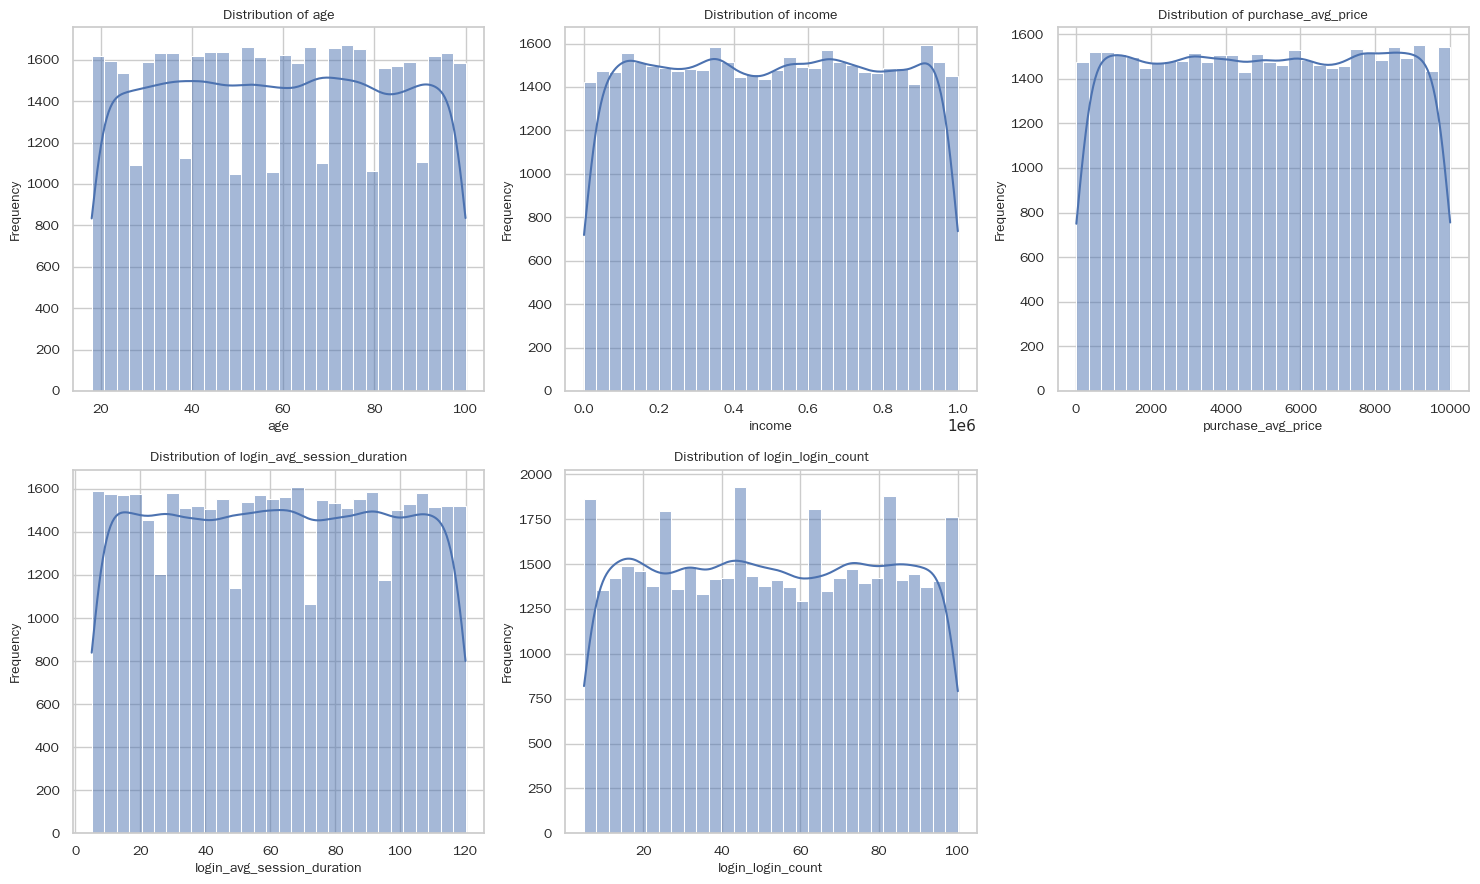

 -> 已保存数值分布直方图: 10G_data_new_numeric_histograms.png

绘制箱线图...


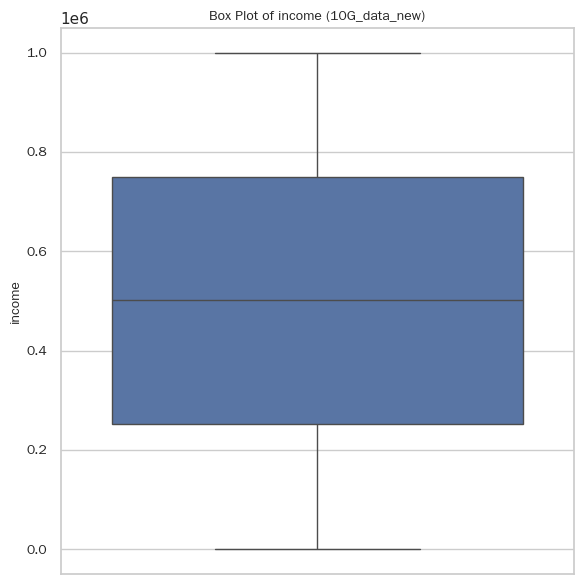

 -> 已保存 income 箱线图: 10G_data_new_numeric_boxplot_income.png


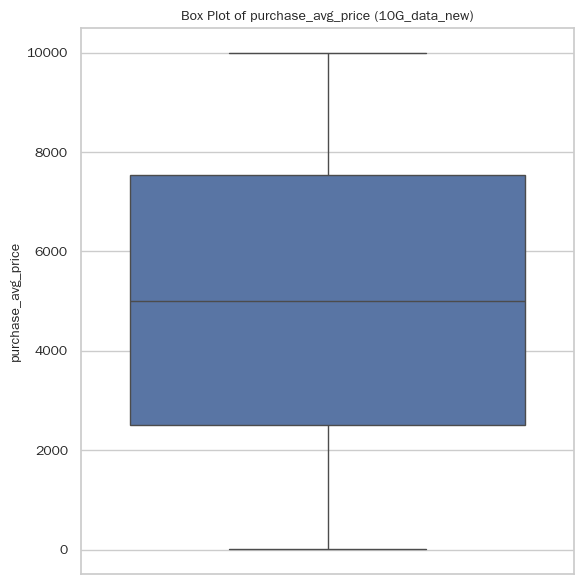

 -> 已保存 purchase_avg_price 箱线图: 10G_data_new_numeric_boxplot_purchase_avg_price.png


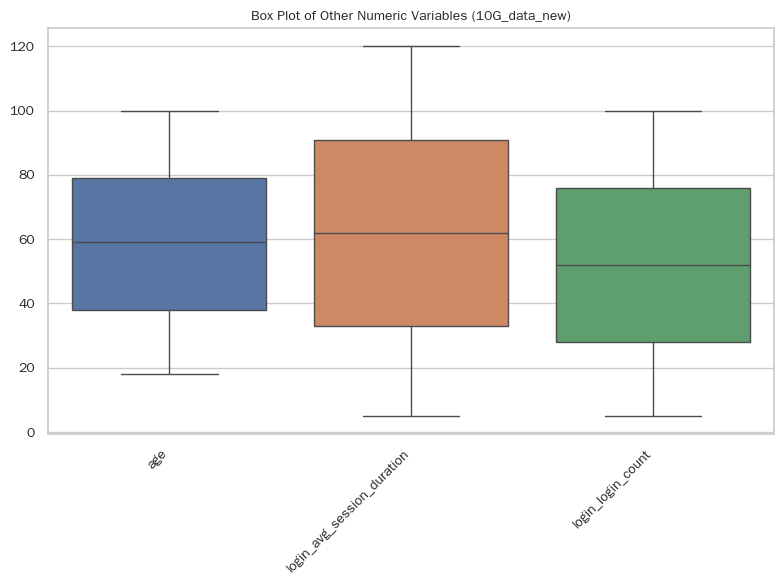

 -> 已保存其他数值变量箱线图: 10G_data_new_numeric_boxplots_others.png

数值数据可视化耗时: 42.96 秒


In [12]:
# --- EDA: 数值型数据统计与分布 ---

desc_duration = 0.0
num_viz_duration = 0.0
plot_pd_df = None # 初始化抽样数据

if df is not None:
    print("\n--- 数值型数据描述性统计 (Spark) ---")
    start_time_desc = time.time()
    # 更新列名列表，确保它们存在于解析后的 df 中
    from pyspark.sql.types import LongType
    numeric_cols = ['age', 'income', 'purchase_avg_price', 'login_avg_session_duration', 'login_login_count', 'purchase_count', 'purchase_items_count', 'login_device_count']
    numeric_cols_exist = [c for c in numeric_cols if c in df.columns and isinstance(df.schema[c].dataType, (IntegerType, DoubleType, LongType))] # 确保是数值类型

    if numeric_cols_exist:
        print(f"对以下数值列进行统计: {numeric_cols_exist}")
        try:
            desc_spark_df = df.select(numeric_cols_exist).describe()
            print("Spark describe() 结果:")
            desc_spark_df.show()
        except Exception as e:
            print(f"计算 describe() 时出错: {e}")
    else:
        print("未找到有效的数值列进行统计。")
    desc_duration = time.time() - start_time_desc
    print(f"\n描述性统计耗时: {desc_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_describe'] = desc_duration


    # --- 绘制数值型数据分布图 (抽样) ---
    print("\n--- 绘制数值型数据分布图 (抽样) ---")
    start_time_num_viz = time.time()
    sample_fraction = 0.001 # 维持 0.1% 抽样比例
    print(f"抽取 {sample_fraction*100:.1f}% 的数据进行绘图...")
    try:
        if numeric_cols_exist:
             plot_pd_df = df.select(numeric_cols_exist).sample(fraction=sample_fraction, seed=42).toPandas()
             print(f"抽样完成，得到 {len(plot_pd_df)} 行数据。")
        else:
             print("无数值列，无法进行抽样绘图。")

        if plot_pd_df is not None and not plot_pd_df.empty:
             # --- 设置绘图字体 ---
             font_prop = None
             if 'found_font_path' in locals() and font_setting_successful:
                 try: font_prop = fm.FontProperties(fname=found_font_path)
                 except Exception as e: print(f"加载字体属性失败: {e}")
             sns.set_theme(style="whitegrid")

             # --- 绘制直方图---
             print("绘制直方图...")
             num_plots = len(numeric_cols_exist)
             ncols = 3
             nrows = (num_plots + ncols - 1) // ncols
             fig1, axes1 = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4.5), squeeze=False)
             axes1 = axes1.flatten()
             plot_index = 0
             for i, col_name in enumerate(numeric_cols_exist):
                 if i < len(axes1):
                     ax = axes1[i]
                     sns.histplot(plot_pd_df[col_name].dropna(), kde=True, bins=30, ax=ax)
                     title = f'Distribution of {col_name}'
                     ax.set_title(title, fontproperties=font_prop if font_prop else None)
                     ax.set_xlabel(col_name, fontproperties=font_prop if font_prop else None)
                     ax.set_ylabel('Frequency', fontproperties=font_prop if font_prop else None)
                     if font_prop:
                        for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)
                     plot_index += 1
             for j in range(plot_index, len(axes1)): axes1[j].set_visible(False)
             plt.tight_layout()
             plot_filename1 = f"{output_prefix}_numeric_histograms.png"
             plt.savefig(plot_filename1)
             plt.show()
             print(f" -> 已保存数值分布直方图: {plot_filename1}")
             plt.close(fig1)

             # --- !! 绘制箱线图 (拆分 Income 和 Purchase Avg Price) !! ---
             print("\n绘制箱线图...")
             # 定义高尺度变量和低尺度变量
             high_scale_vars = ['income', 'purchase_avg_price']
             low_scale_vars = [c for c in numeric_cols_exist if c not in high_scale_vars]

             # 分别绘制高尺度变量
             for var in high_scale_vars:
                 if var in plot_pd_df.columns:
                     plt.figure(figsize=(6, 6))
                     sns.boxplot(y=plot_pd_df[var]) # 使用 y 轴绘制单个变量
                     title = f'Box Plot of {var} ({output_prefix})'
                     plt.title(title, fontproperties=font_prop if font_prop else None)
                     plt.ylabel(var, fontproperties=font_prop if font_prop else None) # 设置 Y 轴标签
                     if font_prop: # 设置刻度字体
                         ax = plt.gca()
                         for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)
                     plt.tight_layout()
                     plot_filename_single = f"{output_prefix}_numeric_boxplot_{var}.png"
                     plt.savefig(plot_filename_single)
                     plt.show()
                     print(f" -> 已保存 {var} 箱线图: {plot_filename_single}")
                     plt.close()

             # 绘制其他低尺度变量
             if low_scale_vars and any(c in plot_pd_df.columns for c in low_scale_vars):
                 plt.figure(figsize=(max(8, len(low_scale_vars) * 1.5), 6))
                 plot_data_low_scale = plot_pd_df[[c for c in low_scale_vars if c in plot_pd_df.columns]] # 选择存在的列
                 sns.boxplot(data=plot_data_low_scale)
                 title = f'Box Plot of Other Numeric Variables ({output_prefix})'
                 plt.title(title, fontproperties=font_prop if font_prop else None)
                 ax = plt.gca(); ax.set_ylabel('') # 移除 Y 轴标签
                 if font_prop:
                     plt.xticks(rotation=45, ha='right', fontproperties=font_prop)
                     for label in ax.get_yticklabels(): label.set_fontproperties(font_prop)
                 else:
                     plt.xticks(rotation=45, ha='right')
                 plt.tight_layout()
                 plot_filename_other = f"{output_prefix}_numeric_boxplots_others.png"
                 plt.savefig(plot_filename_other)
                 plt.show()
                 print(f" -> 已保存其他数值变量箱线图: {plot_filename_other}")
                 plt.close()
             # --- !! ------------------------------------------------- !! ---

        else:
            print("抽样数据为空或无数值列，无法绘图。")

    except Exception as e:
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
         print(f"抽样或数值绘图时出错: {e}")
         import traceback
         print(traceback.format_exc())
         print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    num_viz_duration = time.time() - start_time_num_viz
    print(f"\n数值数据可视化耗时: {num_viz_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_numeric_viz'] = num_viz_duration

else:
    print("DataFrame 'df' 不可用。")


--- 类别型数据分布统计与绘图 ---
计算类别分布...
 -> 计算 'gender' 的分布...
    'gender' Top 5 (已清洗):
  gender     count
0      男  21603397
1      女  21598086
2    未指定    899652
3     其他    898865
 -> 计算 'country' 的分布...
    'country' Top 5 (已清洗):
  country    count
0      英国  4501669
1      法国  4501427
2      美国  4501158
3      巴西  4500526
4      德国  4500370
 -> 计算 'is_active' 的分布...
    'is_active' Top 5 (已清洗):
   is_active     count
0      False  22501308
1       True  22498692
 -> 计算 'purchase_categories' 的分布...
    'purchase_categories' Top 5 (已清洗):
  purchase_categories    count
0                  耳机  1073163
1                  裤子  1072983
2                智能手表  1072778
3                平板电脑  1072704
4                婴儿用品  1072639
 -> 计算 'purchase_payment_method' 的分布...
    'purchase_payment_method' Top 5 (已清洗):
  purchase_payment_method    count
0                      银联  6434053
1                      现金  6429817
2                     信用卡  6428223
3                     支付宝  6427963
4               

/tmp/ipykernel_2108878/1544621296.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(ax=ax, x='count', y=col_name, data=plot_data, orient='h', palette='viridis')
/tmp/ipykernel_2108878/1544621296.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(ax=ax, x='count', y=col_name, data=plot_data, orient='h', palette='viridis')
/tmp/ipykernel_2108878/1544621296.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(ax=ax, x='count', y=col_name, data=plot_data, orient='h', palette='viridis')
/tmp/ipykernel_2108878/15

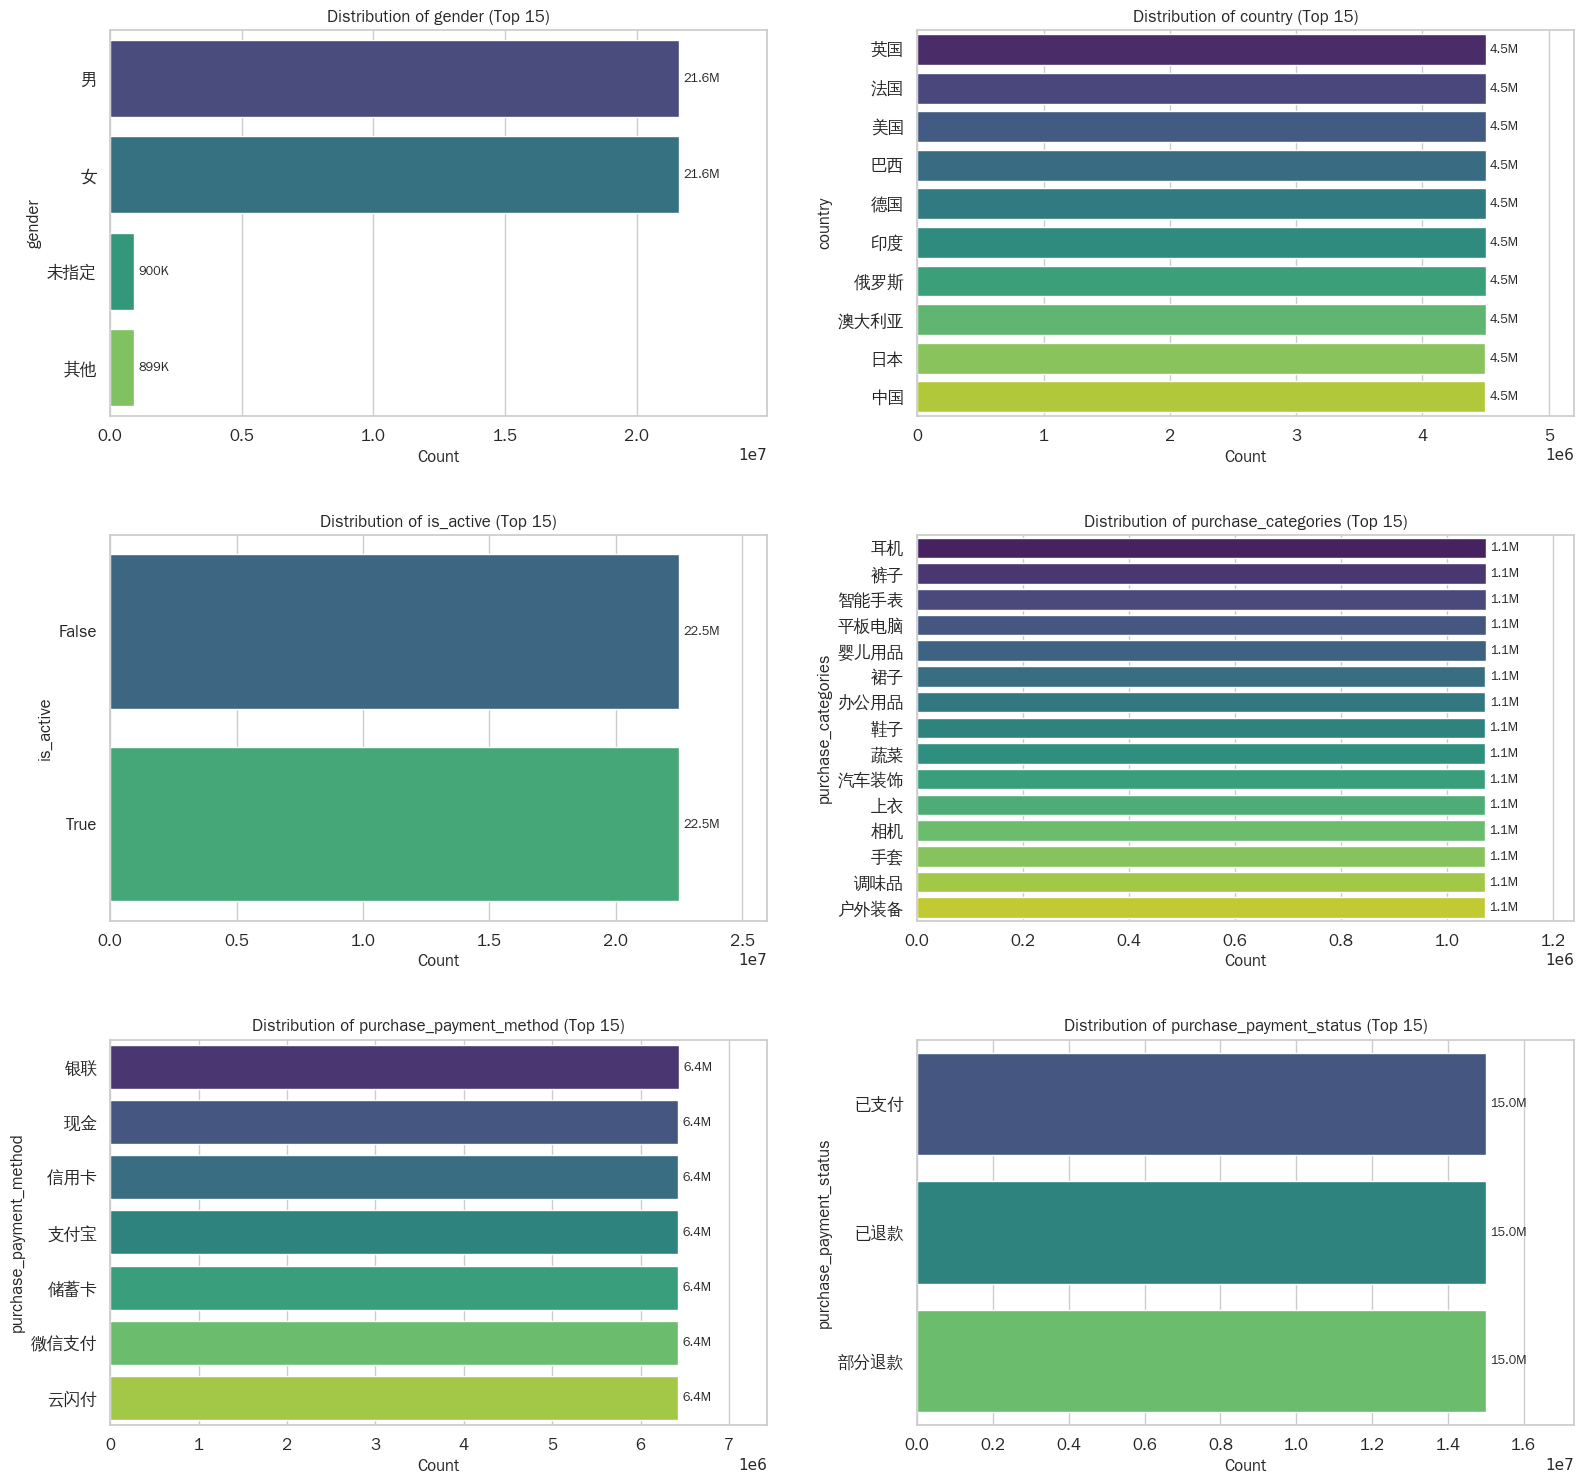

 -> 已保存类别分布图: 10G_data_new_categorical_distributions.png

类别数据分析耗时: 60.65 秒


In [13]:
# --- EDA: 类别型数据分布 ---

cat_duration = 0.0
category_distributions = {} # 存储结果

if df is not None:
    print("\n--- 类别型数据分布统计与绘图 ---")
    start_time_cat = time.time()

    categorical_cols = ['gender', 'country', 'is_active', 'purchase_categories', 'purchase_payment_method', 'purchase_payment_status']
    categorical_cols_exist = [c for c in categorical_cols if c in df.columns]

    print("计算类别分布...")
    for col_name in categorical_cols_exist:
        print(f" -> 计算 '{col_name}' 的分布...")
        try:
            cat_counts_spark = df.groupBy(col_name).count().orderBy(F.desc("count")).limit(50)
            cat_counts_pd = cat_counts_spark.toPandas()
            cat_counts_pd = cat_counts_pd.dropna(subset=[col_name])
            cat_counts_pd = cat_counts_pd[cat_counts_pd[col_name].astype(str) != ''] # 转str确保比较
            category_distributions[col_name] = cat_counts_pd
            print(f"    '{col_name}' Top 5 (已清洗):")
            print(cat_counts_pd.head())
        except Exception as e:
            print(f"    计算 '{col_name}' 分布时出错: {e}")

    # --- 绘制类别型数据分布条形图 (添加数值标签) ---
    print("\n绘制类别分布图...")
    # --- 设置绘图字体 ---
    font_prop = None
    if 'found_font_path' in locals() and font_setting_successful:
         try: font_prop = fm.FontProperties(fname=found_font_path)
         except Exception as e: print(f"加载字体属性失败: {e}")
    sns.set_theme(style="whitegrid")

    num_cat_plots = len(category_distributions)
    if num_cat_plots > 0:
        ncols = 2
        # 动态调整行数和高度
        plot_heights = {}
        total_rows_needed = 0
        for col_name, count_df in category_distributions.items():
             n_cats = len(count_df.head(15)) # Top N
             height = max(3, n_cats * 0.5) # 增加每个类别的高度因子
             plot_heights[col_name] = height
             row_index = list(category_distributions.keys()).index(col_name) // ncols
             if row_index + 1 > total_rows_needed: total_rows_needed = row_index + 1
        total_figure_height = sum(plot_heights[k] for i, k in enumerate(category_distributions.keys()) if i % ncols == 0)
        total_figure_height = max(total_figure_height, total_rows_needed * 5) # 保底高度

        fig, axes = plt.subplots(total_rows_needed, ncols, figsize=(ncols * 8, total_figure_height), squeeze=False) # 增加宽度
        axes = axes.flatten()

        plot_index = 0
        for col_name, count_df in category_distributions.items():
            if not count_df.empty and plot_index < len(axes):
                ax = axes[plot_index]
                top_n = 15
                plot_data = count_df.head(top_n)
                try:
                    # 绘制条形图
                    barplot = sns.barplot(ax=ax, x='count', y=col_name, data=plot_data, orient='h', palette='viridis')

                    # --- !! 添加数值标签 !! ---
                    # 格式化大数字 (例如 K=千, M=百万)
                    def format_large_number(num):
                        if num >= 1e6: return f'{num/1e6:.1f}M'
                        if num >= 1e3: return f'{num/1e3:.0f}K'
                        return f'{num:.0f}'

                    # 为每个条形添加标签
                    for container in barplot.containers:
                         barplot.bar_label(container,
                                           labels=[format_large_number(v) for v in container.datavalues], # 格式化标签
                                           fmt='%.0f', # fmt 参数在这里其实被 labels 覆盖了
                                           fontproperties=font_prop if font_prop else None,
                                           padding=3, # 标签与条形的距离
                                           fontsize=9) # 调小字号避免重叠
                    # --- !! ------------- !! ---

                    title = f'Distribution of {col_name} (Top {top_n})'
                    ax.set_title(title, fontproperties=font_prop if font_prop else None)
                    ax.set_xlabel('Count', fontproperties=font_prop if font_prop else None)
                    ax.set_ylabel(col_name, fontproperties=font_prop if font_prop else None)
                    # 设置刻度标签字体
                    if font_prop:
                         for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)
                    # 调整 X 轴范围，给标签留出空间
                    ax.set_xlim(right=ax.get_xlim()[1] * 1.1) # X轴上限增加 10%

                except Exception as plot_err:
                     print(f"绘制 '{col_name}' 时出错: {plot_err}")
                plot_index += 1

        # 隐藏多余的轴
        for i in range(plot_index, len(axes)): axes[i].set_visible(False)

        plt.tight_layout(h_pad=3.0, w_pad=3.0) # 增加垂直和水平间距
        plot_filename = f"{output_prefix}_categorical_distributions.png"
        plt.savefig(plot_filename)
        plt.show()
        print(f" -> 已保存类别分布图: {plot_filename}")
        plt.close(fig)
    else:
        print("没有可绘制的类别数据。")

    cat_duration = time.time() - start_time_cat
    print(f"\n类别数据分析耗时: {cat_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_categorical_viz'] = cat_duration

else:
    print("DataFrame 'df' 不可用。")


--- 绘制关系图 (基于抽样数据) ---
绘制 Age vs Income Jointplot (Hexbin)...


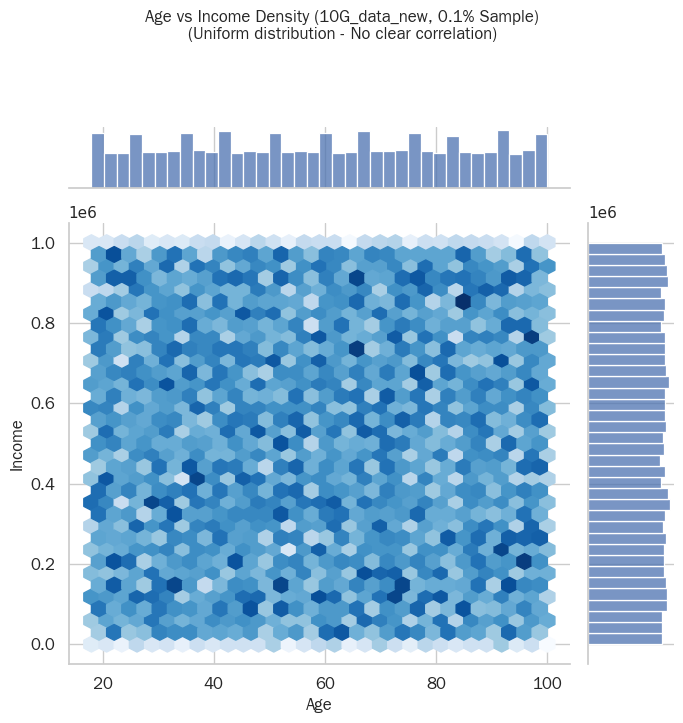

 -> 已保存 Jointplot: 10G_data_new_jointplot_age_income.png

绘制 Income vs Purchase Avg Price Regplot...


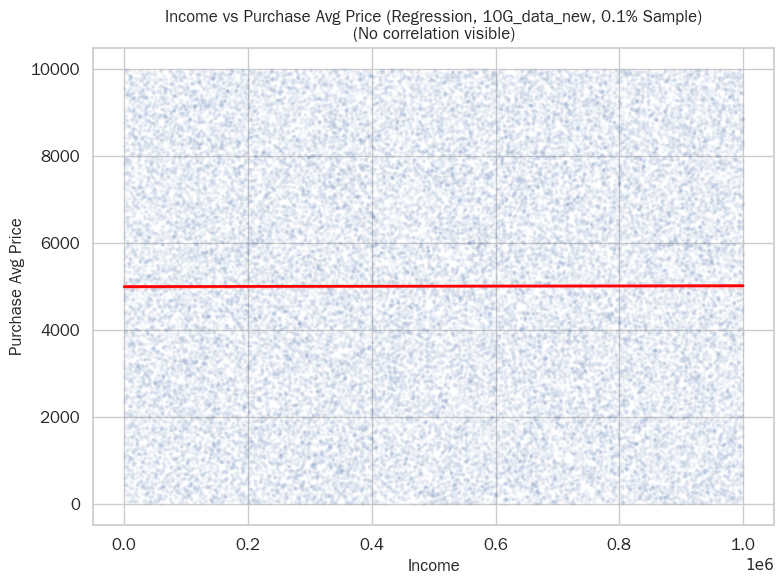

 -> 已保存 Regplot: 10G_data_new_regplot_income_purchase.png

关系图绘制耗时: 2.59 秒


In [14]:
# --- EDA: 散点图探索关系 ---

scatter_viz_duration = 0.0

# 确保之前的抽样数据 plot_pd_df 存在
if df is not None and 'plot_pd_df' in locals() and plot_pd_df is not None:
    print("\n--- 绘制关系图 (基于抽样数据) ---")
    start_time_scatter_viz = time.time()

    # --- 设置绘图字体 ---
    font_prop = None
    if 'found_font_path' in locals() and font_setting_successful:
         try: font_prop = fm.FontProperties(fname=found_font_path)
         except Exception as e: print(f"加载字体属性失败: {e}")
    sns.set_theme(style="whitegrid")

    # --- 示例 1: age vs income (使用 Jointplot hexbin, 调整 gridsize) ---
    if 'age' in plot_pd_df.columns and 'income' in plot_pd_df.columns:
        print("绘制 Age vs Income Jointplot (Hexbin)...")
        try:
            g = sns.jointplot(x='age', y='income', data=plot_pd_df, kind='hex',
                              height=7, joint_kws={'gridsize': 30, 'cmap': 'Blues'}) # 增加网格大小，换颜色
            title_text = f'Age vs Income Density ({output_prefix}, {sample_fraction*100:.1f}% Sample)\n(Uniform distribution - No clear correlation)' # 添加注释
            g.fig.suptitle(title_text, y=1.03, fontproperties=font_prop if font_prop else None)
            g.ax_joint.set_xlabel('Age', fontproperties=font_prop if font_prop else None)
            g.ax_joint.set_ylabel('Income', fontproperties=font_prop if font_prop else None)
            if font_prop:
                 for label in g.ax_joint.get_xticklabels() + g.ax_joint.get_yticklabels(): label.set_fontproperties(font_prop)
                 # Marginals (边缘图) 的字体也可以尝试设置，但比较复杂，先省略

            plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整避免标题重叠
            plot_filename = f"{output_prefix}_jointplot_age_income.png"
            plt.savefig(plot_filename)
            plt.show()
            print(f" -> 已保存 Jointplot: {plot_filename}")
            plt.close(g.fig)
        except Exception as e:
            print(f"绘制 Age vs Income Jointplot 时出错: {e}")
    else:
        print("缺少 'age' 或 'income' 列，无法绘制 Jointplot。")

    # --- 示例 2: income vs purchase_avg_price (使用 Regplot, 调整散点) ---
    if 'income' in plot_pd_df.columns and 'purchase_avg_price' in plot_pd_df.columns:
        print("\n绘制 Income vs Purchase Avg Price Regplot...")
        try:
            plt.figure(figsize=(8, 6))
            sns.regplot(x='income', y='purchase_avg_price', data=plot_pd_df,
                        scatter_kws={'alpha':0.05, 's':3}, # 进一步降低 alpha 和 s
                        line_kws={'color':'red', 'lw':2})
            title = f'Income vs Purchase Avg Price (Regression, {output_prefix}, {sample_fraction*100:.1f}% Sample)\n(No correlation visible)'
            plt.title(title, fontproperties=font_prop if font_prop else None)
            plt.xlabel('Income', fontproperties=font_prop if font_prop else None)
            plt.ylabel('Purchase Avg Price', fontproperties=font_prop if font_prop else None)
            if font_prop:
                ax = plt.gca()
                for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)
            plt.tight_layout()
            plot_filename = f"{output_prefix}_regplot_income_purchase.png"
            plt.savefig(plot_filename)
            plt.show()
            print(f" -> 已保存 Regplot: {plot_filename}")
            plt.close()
        except Exception as e:
             print(f"绘制 Income vs Purchase Regplot 时出错: {e}")
    else:
        print("缺少 'income' 或 'purchase_avg_price' 列，无法绘制 Regplot。")

    scatter_viz_duration = time.time() - start_time_scatter_viz
    print(f"\n关系图绘制耗时: {scatter_viz_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_relation_viz'] = scatter_viz_duration

elif df is None: print("DataFrame 'df' 不可用。")
else: print("抽样数据 'plot_pd_df' 不可用，无法绘制关系图。")


--- 绘制分组条形图 (性别 vs 活跃度) ---
计算按性别分组的活跃用户比例...
绘制各性别活跃用户比例图...


/tmp/ipykernel_2108878/902577451.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="gender", y="active_ratio", data=active_ratio_pd, palette="coolwarm")


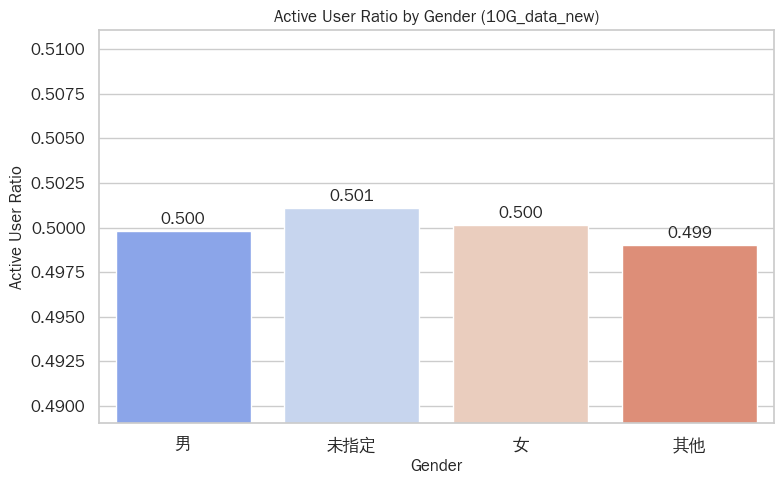

 -> 已保存分组条形图: 10G_data_new_groupedbar_gender_active.png

分组条形图绘制耗时: 1.19 秒


In [15]:
# --- EDA: 分组条形图比较差异 ---

grouped_viz_duration = 0.0

if df is not None:
    print("\n--- 绘制分组条形图 (性别 vs 活跃度) ---")
    start_time_grouped_viz = time.time()

    if 'gender' in df.columns and 'is_active' in df.columns:
        print("计算按性别分组的活跃用户比例...")
        try:
            # 计算比例
            active_ratio_spark = df.groupBy("gender") \
                                   .agg(F.mean(F.col("is_active").cast("double")).alias("active_ratio")) # mean of boolean (as 0/1) gives ratio
            active_ratio_pd = active_ratio_spark.toPandas()

            # --- 设置绘图字体 ---
            font_prop = None
            if 'found_font_path' in locals() and font_setting_successful:
                 try: font_prop = fm.FontProperties(fname=found_font_path)
                 except Exception as e: print(f"加载字体属性失败: {e}")
            sns.set_theme(style="whitegrid")

            # 绘制条形图
            print("绘制各性别活跃用户比例图...")
            plt.figure(figsize=(8, 5))
            ax = sns.barplot(x="gender", y="active_ratio", data=active_ratio_pd, palette="coolwarm")

            # --- !! 调整 Y 轴范围并添加数值标签 !! ---
            # 计算最小和最大比例，给一点边距
            min_ratio = active_ratio_pd['active_ratio'].min()
            max_ratio = active_ratio_pd['active_ratio'].max()
            # 放大差异，但避免过度放大
            margin = (max_ratio - min_ratio) * 0.5 # 设定边距为差异的一半
            margin = max(margin, 0.01) # 保证至少 0.01 的边距
            ax.set_ylim(max(0, min_ratio - margin), min(1, max_ratio + margin)) # 调整 Y 轴范围

            # 添加数值标签
            for container in ax.containers:
                 ax.bar_label(container, fmt='%.3f', # 显示3位小数
                              fontproperties=font_prop if font_prop else None, # 应用字体
                              padding=3) # 标签与条形的距离
            # --- !! ------------------------------ !! ---

            title = f'Active User Ratio by Gender ({output_prefix})'
            plt.title(title, fontproperties=font_prop if font_prop else None)
            plt.xlabel('Gender', fontproperties=font_prop if font_prop else None)
            plt.ylabel('Active User Ratio', fontproperties=font_prop if font_prop else None)
            if font_prop: # 设置刻度字体
                 for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)
            plt.tight_layout()
            plot_filename = f"{output_prefix}_groupedbar_gender_active.png"
            plt.savefig(plot_filename)
            plt.show()
            print(f" -> 已保存分组条形图: {plot_filename}")
            plt.close()

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"计算或绘制分组条形图时出错: {e}")
            import traceback
            print(traceback.format_exc())
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    else:
        print("缺少 'gender' 或 'is_active' 列，无法绘制分组条形图。")

    grouped_viz_duration = time.time() - start_time_grouped_viz
    print(f"\n分组条形图绘制耗时: {grouped_viz_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_grouped_viz'] = grouped_viz_duration

else:
    print("DataFrame 'df' 不可用。")

## 4. 分析目标：识别潜在高价值用户 (RFM 模型)

In [16]:
# --- RFM 分析：数据准备 ---

rfm_prep_duration = 0.0

if df is not None:
    print("\n--- 准备 RFM 分析所需数据 ---")
    start_time_rfm_prep = time.time()

    # --- 1. 转换购买日期 ---
    print("转换 purchase_purchase_date 为 Date 类型...")
    if "purchase_purchase_date" in df.columns:
        # 假设 purchase_purchase_date 是 'yyyy-MM-dd' 格式
        df = df.withColumn("purchase_date_dt", F.to_date(F.col("purchase_purchase_date"), "yyyy-MM-dd"))
        # 计算转换失败的数量 (新的 NaT)
        original_nulls = df.filter(F.col("purchase_purchase_date").isNull()).count()
        nat_dates = df.filter(F.col("purchase_date_dt").isNull() & F.col("purchase_purchase_date").isNotNull()).count()
        if nat_dates > 0: print(f" -> 警告: purchase_purchase_date 转换时产生 {nat_dates} 个 null 值 (NaT)。")
        nat_summary['purchase_date_dt'] = nat_dates # 添加到 NaT 统计
    else:
        print("警告: 列 'purchase_purchase_date' 不存在，无法进行 Recency 计算。")
        df = df.withColumn("purchase_date_dt", F.lit(None).cast("date")) # 添加空列


    # --- 2. 计算 F (Frequency) 和 M (Monetary) 的基础 ---
    print("计算 Frequency 和 Monetary 的基础列...")
    # Frequency: 使用 purchase_items 数组的大小 (如果解析失败则为 NaN)
    if "purchase_items" in df.columns and isinstance(df.schema["purchase_items"].dataType, ArrayType):
        # 当 items 为 null 时 size 返回 null， coalesce 转为 0
        df = df.withColumn("purchase_frequency_base", F.coalesce(F.size(F.col("purchase_items")), F.lit(0)))
    else:
        print("警告: 列 'purchase_items' 非数组或不存在。Frequency 将基于记录数 (设为 1)。")
        df = df.withColumn("purchase_frequency_base", F.lit(1))

    # Monetary: purchase_avg_price * purchase_frequency_base (处理 null)
    if "purchase_avg_price" in df.columns and "purchase_frequency_base" in df.columns:
        df = df.withColumn("purchase_monetary_base",
                           F.col("purchase_avg_price") * F.col("purchase_frequency_base"))
        # 将计算结果为 null 或负数的设为 0
        df = df.withColumn("purchase_monetary_base",
                           F.when(F.col("purchase_monetary_base").isNull() | (F.col("purchase_monetary_base") < 0), 0.0)
                           .otherwise(F.col("purchase_monetary_base")))
    else:
        print("警告: 列 'purchase_avg_price' 或 frequency 基础列不存在。Monetary 设为 0。")
        df = df.withColumn("purchase_monetary_base", F.lit(0.0))

    # --- 3. 确定 Recency 的参考日期 ---
    print("确定 Recency 计算的参考日期...")
    reference_date = None
    if "purchase_date_dt" in df.columns:
        try:
            # 计算数据中最大的购买日期 + 1天
            max_date = df.agg(F.max("purchase_date_dt")).first()[0]
            if max_date:
                reference_date_df = spark.createDataFrame([(max_date,)], ['max_d'])
                reference_date = reference_date_df.select(F.date_add(F.col("max_d"), 1).alias("ref_d")).first()['ref_d']
                print(f"数据中最大购买日期: {max_date}, 使用参考日期: {reference_date}")
            else:
                print("警告: 无法确定最大购买日期，将使用当前日期作为参考。")
                from datetime import date
                reference_date = date.today() # 使用今天的日期
                print(f"使用当前日期作为参考: {reference_date}")
        except Exception as e:
            print(f"获取最大日期时出错: {e}")
            from datetime import date
            reference_date = date.today()
            print(f"出错，使用当前日期作为参考: {reference_date}")
    else:
        print("无购买日期列，无法设置参考日期，Recency 将无法计算。")

    # 显示添加了基础列后的数据样例
    print("\n添加了 RFM 基础列后的 Schema:")
    df.printSchema()
    print("\n添加了 RFM 基础列后的样例数据:")
    cols_to_show_rfm_base = ['id', 'purchase_date_dt', 'purchase_frequency_base', 'purchase_monetary_base']
    try:
        df.select(*cols_to_show_rfm_base).show(5)
    except Exception as e:
        print(f"显示样例数据时出错: {e}")

    end_time_rfm_prep = time.time()
    rfm_prep_duration = end_time_rfm_prep - start_time_rfm_prep
    print(f"\nRFM 数据准备耗时: {rfm_prep_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_rfm_prep'] = rfm_prep_duration

else:
    print("DataFrame 'df' 不可用。")


--- 准备 RFM 分析所需数据 ---
转换 purchase_purchase_date 为 Date 类型...
计算 Frequency 和 Monetary 的基础列...
确定 Recency 计算的参考日期...
数据中最大购买日期: 2025-03-24, 使用参考日期: 2025-03-25

添加了 RFM 基础列后的 Schema:
root
 |-- id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- last_login: timestamp (nullable = true)
 |-- registration_date: timestamp (nullable = true)
 |-- purchase_avg_price: double (nullable = true)
 |-- purchase_categories: string (nullable = true)
 |-- purchase_items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |-- purchase_payment_method: string (nullable = true)


In [17]:
# --- RFM 分析：计算指标并打分 ---

rfm_calc_duration = 0.0
rfm_df = None # 初始化

# 确保上一步成功并且参考日期已确定
if df is not None and 'reference_date' in locals() and reference_date:
    print(f"\n--- 计算 RFM 指标 (参考日期: {reference_date}) ---")
    start_time_rfm_calc = time.time()

    # 将 reference_date 转换为 Spark 能理解的字面量
    ref_date_lit = F.lit(reference_date).cast(TimestampType())

    print("按用户聚合计算 R, F, M...")
    try:
        rfm_agg_df = df.groupBy("id").agg(
            F.max("purchase_date_dt").alias("last_purchase_date"), # 最近购买日期
            F.sum("purchase_frequency_base").alias("Frequency"),   # 总频率
            F.sum("purchase_monetary_base").alias("Monetary")      # 总金额
        )

        # 计算 Recency (天数差)
        rfm_agg_df = rfm_agg_df.withColumn(
             "Recency",
             F.when(F.col("last_purchase_date").isNotNull(),
                    F.datediff(ref_date_lit, F.col("last_purchase_date")))
             .otherwise(None)
        )

        # 处理 F 和 M 可能为 null 的情况
        rfm_agg_df = rfm_agg_df.fillna(0, subset=['Frequency', 'Monetary'])

        # --- RFM 打分 (1-5分) ---
        print("\n计算 RFM 分数 (1-5分，分数越高越好)...")

        # --- !! 修正 Window 定义 !! ---
        # orderBy() 直接接收 Column 对象作为参数
        window_r = Window.orderBy(F.col("Recency").asc_nulls_last())  # 使用 asc_nulls_last() 更简洁
        # 或者保持原样: Window.orderBy(F.col("Recency").asc().nulls_last()) # 不带最后的 ()
        window_f = Window.orderBy(F.col("Frequency").desc_nulls_last()) # F 和 M 也加上 nulls_last/first 保证确定性
        window_m = Window.orderBy(F.col("Monetary").desc_nulls_last())
        # --- !! -------------------- !! ---

        rfm_scored_df = rfm_agg_df.withColumn("R_score_raw", F.ntile(5).over(window_r))
        # --- !! 修正 R 分数反转逻辑 !! ---
        # 如果 R_score_raw 是 1(最好) 到 5(最差), 那 R_score 应该是 6 - R_score_raw
        # null 值对应的 R_score_raw 是 null, 6 - null 还是 null, 需要 fillna
        rfm_scored_df = rfm_scored_df.withColumn("R_score",
                                                 F.when(F.col("R_score_raw").isNotNull(), 6 - F.col("R_score_raw"))
                                                 .otherwise(0)) # R为null(从未购买)的用户得0分
        # --- !! ---------------------- !! ---
        rfm_scored_df = rfm_scored_df.withColumn("F_score", F.ntile(5).over(window_f)).fillna(0, subset=['F_score']) # F=0 的用户也给0分
        rfm_scored_df = rfm_scored_df.withColumn("M_score", F.ntile(5).over(window_m)).fillna(0, subset=['M_score']) # M=0 的用户也给0分


        # 计算 RFM 总分
        rfm_scored_df = rfm_scored_df.withColumn("RFM_Score", F.col("R_score") + F.col("F_score") + F.col("M_score"))

        # 清理临时列
        rfm_scored_df = rfm_scored_df.drop("R_score_raw")

        # --- 显示 RFM 结果 ---
        print("\nRFM 指标和分数计算完成。样例数据:")
        rfm_scored_df.select("id", "Recency", "Frequency", "Monetary", "R_score", "F_score", "M_score", "RFM_Score")\
                     .orderBy(F.desc("RFM_Score"), F.desc("Monetary"))\
                     .show(10)

        # --- 缓存 RFM 结果 ---
        print("\n缓存 RFM 结果...")
        rfm_scored_df.cache()
        rfm_user_count = rfm_scored_df.count()
        print(f"已缓存 {rfm_user_count} 个用户的 RFM 分数。")
        # 检查用户数 (此时 rfm_user_count 应该是唯一用户数)
        # 我们需要的是原始行数 total_rows
        # 这里的比较逻辑可能不准确，因为 rfM 是按用户聚合的
        # print(f"原始总行数: {total_rows}") # 提示信息

        rfm_df = rfm_scored_df # 赋值给后续步骤使用

    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"RFM 指标计算或打分时出错: {e}")
        import traceback
        print(traceback.format_exc())
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        rfm_df = None

    end_time_rfm_calc = time.time()
    rfm_calc_duration = end_time_rfm_calc - start_time_rfm_calc
    print(f"\nRFM 指标计算与打分耗时: {rfm_calc_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_rfm_calc'] = rfm_calc_duration

else:
    print("DataFrame 'df' 或 reference_date 不可用，无法进行 RFM 计算。")
    rfm_df = None # 确保 rfm_df 为 None


--- 计算 RFM 指标 (参考日期: 2025-03-25) ---
按用户聚合计算 R, F, M...

计算 RFM 分数 (1-5分，分数越高越好)...

RFM 指标和分数计算完成。样例数据:


25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:22:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 0

+--------+-------+---------+--------+-------+-------+-------+---------+
|      id|Recency|Frequency|Monetary|R_score|F_score|M_score|RFM_Score|
+--------+-------+---------+--------+-------+-------+-------+---------+
|44720753|      1|        1|  4395.0|      5|      5|      5|       15|
| 9562792|     22|        1|  4395.0|      5|      5|      5|       15|
|25039584|      7|        1|  4395.0|      5|      5|      5|       15|
|11552071|      9|        1|  4395.0|      5|      5|      5|       15|
|16798827|      9|        1|  4395.0|      5|      5|      5|       15|
|15657392|      9|        1|  4395.0|      5|      5|      5|       15|
|44666200|     10|        1|  4395.0|      5|      5|      5|       15|
| 8860536|     10|        1|  4395.0|      5|      5|      5|       15|
|31235556|     15|        1|  4395.0|      5|      5|      5|       15|
|20249840|     16|        1|  4395.0|      5|      5|      5|       15|
+--------+-------+---------+--------+-------+-------+-------+---

25/04/20 05:23:57 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.
25/04/20 05:23:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:23:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:23:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:23:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/20 05:23:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition

已缓存 45000000 个用户的 RFM 分数。

RFM 指标计算与打分耗时: 279.13 秒



--- 分析 RFM 分数分布 ---
计算 R, F, M, RFM 总分的分布...
绘制 RFM 分数分布图...


/tmp/ipykernel_2108878/1372764227.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = axes[0]; sns.barplot(ax=ax1, x="R_score", y="count", data=r_dist, palette="Blues_d"); ax1.set_title("Recency Score", fontproperties=font_prop if font_prop else None); add_labels(ax1)
/tmp/ipykernel_2108878/1372764227.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = axes[1]; sns.barplot(ax=ax2, x="F_score", y="count", data=f_dist, palette="Greens_d"); ax2.set_title("Frequency Score", fontproperties=font_prop if font_prop else None); add_labels(ax2)
/tmp/ipykernel_2108878/1372764227.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variab

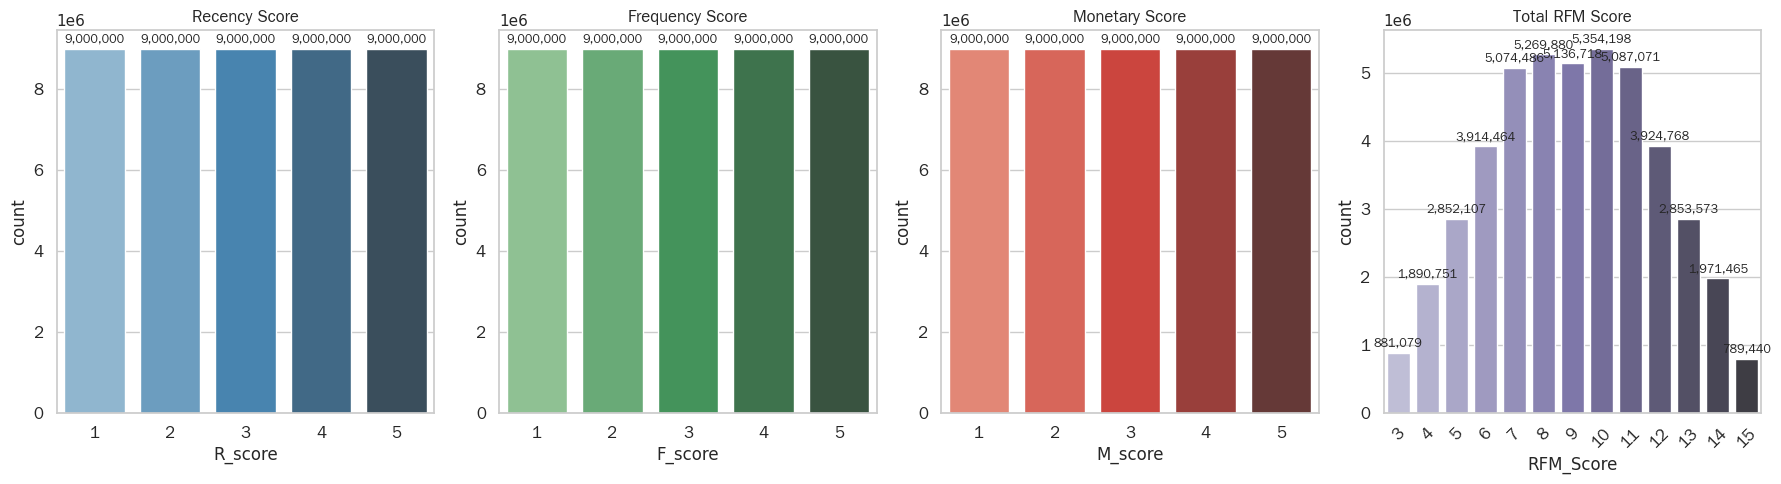

 -> 已保存 RFM 分数分布图: 10G_data_new_rfm_score_distributions.png

--- 识别高价值用户 (R>=4, F>=4, M>=4) ---
总用户数: 45000000
共识别出 4732757 位高价值用户，占总用户数的 10.52%.

--- 分析高价值用户特征 ---
将高价值用户信息与原始数据关联 (Join)...
关联完成，缓存结果...


25/04/20 05:27:13 WARN SQLConf: The SQL config 'spark.sql.legacy.parquet.datetimeRebaseModeInRead' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.parquet.datetimeRebaseModeInRead' instead.


得到 4732757 条高价值用户记录。

高价值用户基本统计 (年龄, 收入, RFM分数):
+-------+------------------+------------------+------------------+
|summary|               age|            income|         RFM_Score|
+-------+------------------+------------------+------------------+
|  count|           4732757|           4732757|           4732757|
|   mean|59.010905905373974|499845.65949486516|13.666985015288128|
| stddev|23.958599078670076|  288629.131289062|0.8497537287278923|
|    min|                18|              0.13|                12|
|    max|               100|         999999.96|                15|
+-------+------------------+------------------+------------------+


绘制高价值用户特征分布...
对比年龄分布...


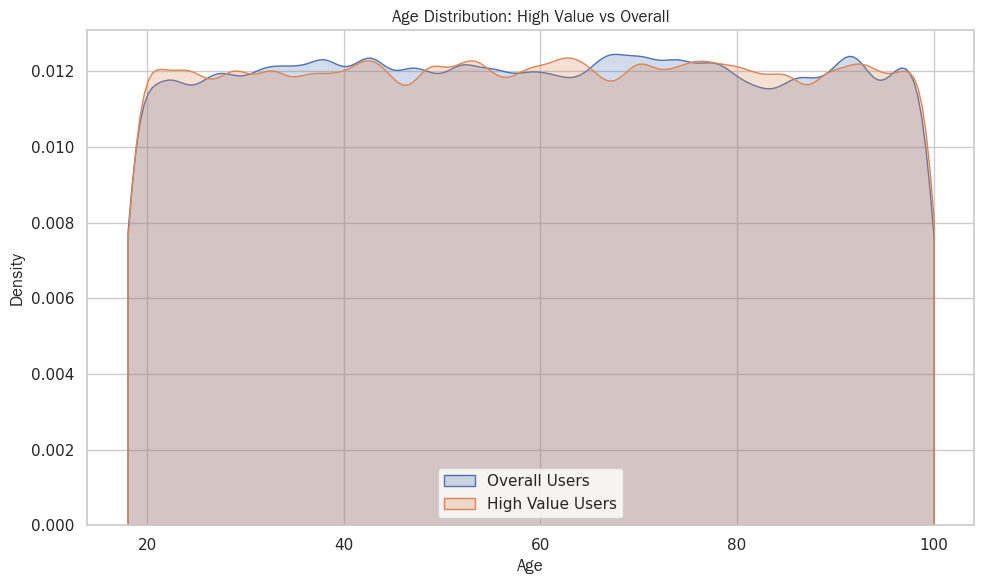

 -> 已保存高价值用户年龄对比图。

对比国家分布...


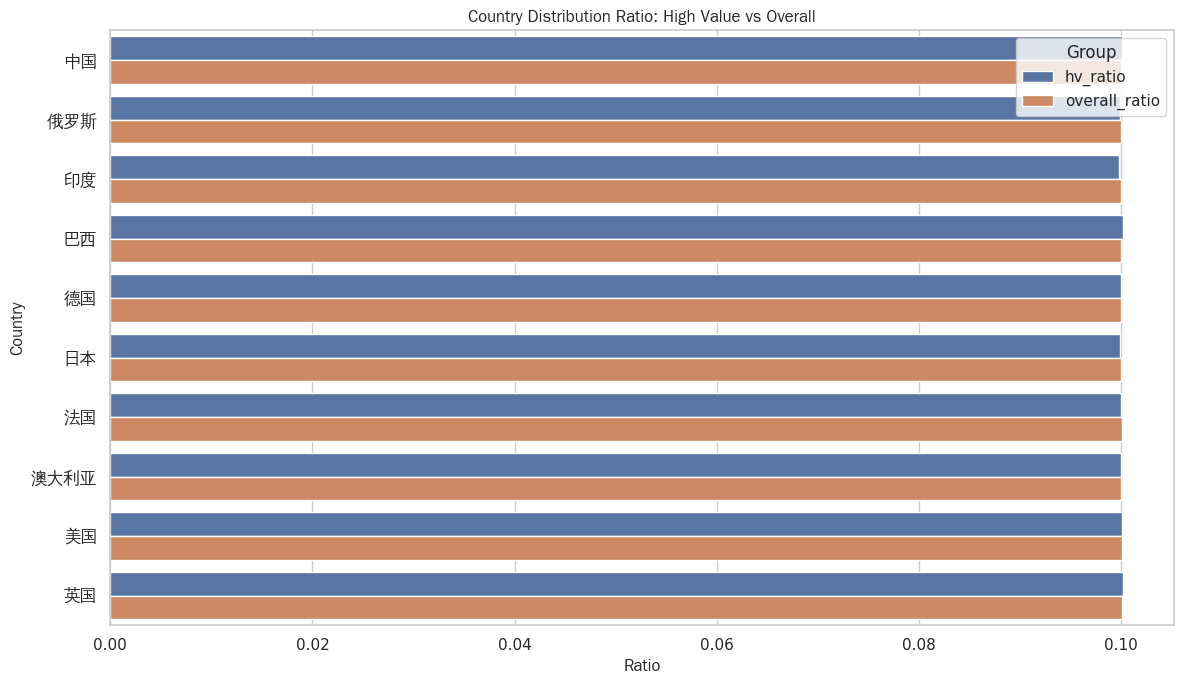

 -> 已保存高价值用户国家对比图。

高价值用户常用设备分析:
Top 5 Devices used by High Value Users:
    device    count
0   mobile  2513009
1  desktop  2512189
2   tablet  2510547


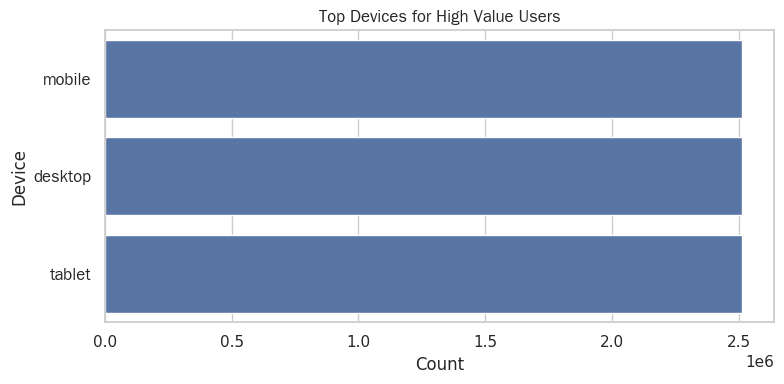

 -> 已保存高价值用户 Top 设备图。

RFM 结果分析与可视化耗时: 74.24 秒


In [18]:
# --- RFM 分析：结果分析与可视化 ---

rfm_viz_duration = 0.0

# 确保上一步的 rfm_df 存在
if 'rfm_df' in locals() and rfm_df is not None:
    print("\n--- 分析 RFM 分数分布 ---")
    start_time_rfm_viz = time.time()

    # --- 1. 获取 RFM 分数的统计信息 & 绘制分布图 ---
    print("计算 R, F, M, RFM 总分的分布...")
    try:
        r_dist = rfm_df.groupBy("R_score").count().orderBy("R_score").toPandas()
        f_dist = rfm_df.groupBy("F_score").count().orderBy("F_score").toPandas()
        m_dist = rfm_df.groupBy("M_score").count().orderBy("M_score").toPandas()
        rfm_total_dist = rfm_df.groupBy("RFM_Score").count().orderBy("RFM_Score").toPandas()

        print("绘制 RFM 分数分布图...")
        # --- 设置绘图字体 ---
        font_prop = None
        if 'found_font_path' in locals() and font_setting_successful:
             try: font_prop = fm.FontProperties(fname=found_font_path)
             except Exception as e: print(f"加载字体属性失败: {e}")
        sns.set_theme(style="whitegrid")

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))

        # Function to add labels to bars
        def add_labels(ax):
             for container in ax.containers:
                 # Format labels (e.g., as integer strings)
                 labels = [f'{int(v.get_height()):,}' for v in container]
                 ax.bar_label(container, labels=labels, label_type='edge',
                              fontproperties=font_prop if font_prop else None,
                              fontsize=9, padding=3)

        # R score distribution
        ax1 = axes[0]; sns.barplot(ax=ax1, x="R_score", y="count", data=r_dist, palette="Blues_d"); ax1.set_title("Recency Score", fontproperties=font_prop if font_prop else None); add_labels(ax1)
        # F score distribution
        ax2 = axes[1]; sns.barplot(ax=ax2, x="F_score", y="count", data=f_dist, palette="Greens_d"); ax2.set_title("Frequency Score", fontproperties=font_prop if font_prop else None); add_labels(ax2)
        # M score distribution
        ax3 = axes[2]; sns.barplot(ax=ax3, x="M_score", y="count", data=m_dist, palette="Reds_d"); ax3.set_title("Monetary Score", fontproperties=font_prop if font_prop else None); add_labels(ax3)
        # RFM Total score distribution
        ax4 = axes[3]; sns.barplot(ax=ax4, x="RFM_Score", y="count", data=rfm_total_dist, palette="Purples_d"); ax4.set_title("Total RFM Score", fontproperties=font_prop if font_prop else None); ax4.tick_params(axis='x', rotation=45); add_labels(ax4)

        # 设置所有子图刻度字体 (如果需要)
        if font_prop:
             for ax in axes:
                 for label in ax.get_xticklabels() + ax.get_yticklabels(): label.set_fontproperties(font_prop)

        plt.tight_layout()
        plot_filename = f"{output_prefix}_rfm_score_distributions.png"
        plt.savefig(plot_filename)
        plt.show(); print(f" -> 已保存 RFM 分数分布图: {plot_filename}"); plt.close(fig)

    except Exception as e:
        print(f"计算或绘制 RFM 分数分布时出错: {e}")
        import traceback; print(traceback.format_exc())


    # --- 2. 定义高价值用户---
    high_value_threshold_r = 4; high_value_threshold_f = 4; high_value_threshold_m = 4
    print(f"\n--- 识别高价值用户 (R>={high_value_threshold_r}, F>={high_value_threshold_f}, M>={high_value_threshold_m}) ---")
    high_value_users = None; high_value_count = 0; total_user_count = 0
    try:
        high_value_users_filter = (F.col("R_score") >= high_value_threshold_r) & (F.col("F_score") >= high_value_threshold_f) & (F.col("M_score") >= high_value_threshold_m)
        high_value_users = rfm_df.filter(high_value_users_filter)
        counts = rfm_df.agg(F.count("*").alias("total_users"), F.sum(F.when(high_value_users_filter, 1).otherwise(0)).alias("high_value_users")).first()
        total_user_count = counts['total_users']; high_value_count = counts['high_value_users']
        if total_user_count > 0:
             high_value_percentage = (high_value_count / total_user_count) * 100
             print(f"总用户数: {total_user_count}")
             print(f"共识别出 {high_value_count} 位高价值用户，占总用户数的 {high_value_percentage:.2f}%.")
        else: print("总用户数为 0。")
    except Exception as e: print(f"识别高价值用户时出错: {e}"); high_value_users = None; high_value_count = 0


    # --- 3. 分析高价值用户特征---
    if high_value_users is not None and high_value_count > 0:
        print("\n--- 分析高价值用户特征 ---")
        try:
            print("将高价值用户信息与原始数据关联 (Join)...")
            original_cols_to_select = ["id", "age", "gender", "country", "is_active", "purchase_categories", "login_devices", "income"]
            original_cols_to_select = [c for c in original_cols_to_select if c in df.columns]
            original_df_selected = df.select(*original_cols_to_select)
            high_value_details = original_df_selected.join(F.broadcast(high_value_users.select("id", "RFM_Score")), on="id", how="inner")
            print("关联完成，缓存结果..."); high_value_details.cache(); actual_join_count = high_value_details.count()
            print(f"得到 {actual_join_count} 条高价值用户记录。")

            # --- a) 基本统计---
            print("\n高价值用户基本统计 (年龄, 收入, RFM分数):")
            stats_cols = ['age', 'income', 'RFM_Score']; stats_cols_exist = [c for c in stats_cols if c in high_value_details.columns]
            if stats_cols_exist: high_value_details.select(*stats_cols_exist).summary("count", "mean", "stddev", "min", "max").show()
            else: print("缺少统计所需列。")

            # --- b) 绘制特征分布 (KDE对比图) ---
            print("\n绘制高价值用户特征分布...")
            if 'plot_pd_df' in locals() and plot_pd_df is not None and 'age' in plot_pd_df.columns and 'age' in high_value_details.columns:
                print("对比年龄分布...")
                hv_age_pd = None; sample_size_hv = min(actual_join_count, 50000)
                if actual_join_count > 0: hv_age_pd = high_value_details.select('age').sample(fraction=sample_size_hv/actual_join_count, seed=42).toPandas()
                if hv_age_pd is not None and not hv_age_pd.empty:
                     plt.figure(figsize=(10, 6))
                     sns.kdeplot(plot_pd_df['age'].dropna(), label='Overall Users', fill=True, bw_adjust=.5, cut=0)
                     sns.kdeplot(hv_age_pd['age'].dropna(), label='High Value Users', fill=True, bw_adjust=.5, cut=0)
                     plt.title('Age Distribution: High Value vs Overall', fontproperties=font_prop if font_prop else None)
                     plt.xlabel('Age', fontproperties=font_prop if font_prop else None); plt.ylabel('Density', fontproperties=font_prop if font_prop else None)
                     plt.legend(); plt.tight_layout(); plt.savefig(f"{output_prefix}_high_value_age_comparison.png"); plt.show(); print(" -> 已保存高价值用户年龄对比图。"); plt.close()
                else: print("高价值用户年龄数据无法用于绘图。")
            else: print("无法绘制年龄对比图 (缺少数据)。")

            # 对比 Country 分布 (比例条形图)
            if 'country' in df.columns and 'country' in high_value_details.columns:
                 print("\n对比国家分布...")
                 # Calculate country_counts
                 country_counts = df.groupBy("country").count().toPandas()
                 country_counts = pd.Series(country_counts['count'].values, index=country_counts['country']).to_dict()
                 
                 hv_country_dist_spark = high_value_details.groupBy("country").count()
                 hv_country_dist = hv_country_dist_spark.toPandas()
                 overall_country_dist = pd.Series(country_counts).reset_index(); overall_country_dist.columns = ['country', 'overall_count']
                 compare_country = pd.merge(hv_country_dist, overall_country_dist, on='country', how='left')
                 compare_country['hv_ratio'] = compare_country['count'] / actual_join_count if actual_join_count > 0 else 0
                 compare_country['overall_ratio'] = compare_country['overall_count'] / total_user_count if total_user_count > 0 else 0
                 compare_country_melt = compare_country.melt(id_vars='country', value_vars=['hv_ratio', 'overall_ratio'], var_name='Group', value_name='Ratio').sort_values(by=['country','Group'])
                 plt.figure(figsize=(12, 7)); ax = sns.barplot(x='Ratio', y='country', hue='Group', data=compare_country_melt, orient='h')
                 plt.title('Country Distribution Ratio: High Value vs Overall', fontproperties=font_prop if font_prop else None)
                 plt.xlabel('Ratio', fontproperties=font_prop if font_prop else None); plt.ylabel('Country', fontproperties=font_prop if font_prop else None)
                 if font_prop:
                      for label in ax.get_yticklabels(): label.set_fontproperties(font_prop)
                 plt.legend(title='Group'); plt.tight_layout()
                 plt.savefig(f"{output_prefix}_high_value_country_comparison.png"); plt.show(); print(" -> 已保存高价值用户国家对比图。"); plt.close()
            else: print("无法绘制国家对比图 (缺少数据)。")

            # --- 分析高价值用户的设备 (条形图) ---
            if 'login_devices' in high_value_details.columns:
                print("\n高价值用户常用设备分析:")
                try:
                    hv_devices = high_value_details.withColumn("device", F.explode("login_devices")).groupBy("device").count().orderBy(F.desc("count")).toPandas()
                    print("Top 5 Devices used by High Value Users:")
                    print(hv_devices.head())
                    plt.figure(figsize=(8, max(4, len(hv_devices.head())*0.6))); ax = sns.barplot(x='count', y='device', data=hv_devices.head(), orient='h')
                    plt.title('Top Devices for High Value Users', fontproperties=font_prop if font_prop else None); plt.xlabel('Count'); plt.ylabel('Device')
                    if font_prop:
                         for label in ax.get_yticklabels(): label.set_fontproperties(font_prop)
                    plt.tight_layout(); plt.savefig(f"{output_prefix}_high_value_top_devices.png"); plt.show(); print(" -> 已保存高价值用户 Top 设备图。"); plt.close()
                except Exception as e: print(f"分析设备时出错: {e}")
            else: print("缺少 'login_devices' 列，无法分析。")

            # 清理缓存
            high_value_details.unpersist()

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"); print(f"分析高价值用户特征时出错: {e}")
            import traceback; print(traceback.format_exc()); print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    elif high_value_count == 0: print("未识别到符合条件的高价值用户。")
    else: print("无法分析高价值用户特征，因为识别步骤失败。")

    end_time_rfm_viz = time.time()
    rfm_viz_duration = end_time_rfm_viz - start_time_rfm_viz
    print(f"\nRFM 结果分析与可视化耗时: {rfm_viz_duration:.2f} 秒")
    if 'processing_times' not in locals(): processing_times = {}
    processing_times[output_prefix + '_rfm_analysis'] = rfm_calc_duration + rfm_viz_duration

else:
    print("RFM DataFrame 'rfm_df' 不可用。")

In [19]:
# --- 最终数据质量报告 ---

# 确保所有统计量都已计算
final_report_vars = ['total_rows', 'missing_values_summary', 'duplicate_count',
                     'json_parsing_success_counts', 'nat_summary', 'outlier_counts',
                     'consistency_issues']
if all(v in locals() or v in globals() for v in final_report_vars):
    print("\n" + "="*60)
    print(f"--- {output_prefix} 最终数据质量与预处理报告 ---")
    print("="*60)

    # 0. 行数信息
    print(f"0. 初始总行数: {total_rows}")
    print(f"   处理动作: 本次运行中未因预处理显式删除任何行。")

    # 1. Missing Values & NaT
    print("\n1. 缺失值与日期转换问题 (NaT):")
    has_missing_or_nat = False
    if missing_values_summary:
        overall_missing_info = missing_values_summary.get('overall')
        if overall_missing_info:
             print(f" - {overall_missing_info}") # 假设这个变量是英文，或者根据实际情况修改
             if 'No missing values found' in overall_missing_info: has_missing_or_nat = False
        else:
             print("   缺失值统计 (原始列):")
             for col, data in sorted(missing_values_summary.items()):
                 if data['count'] > 0:
                     print(f"    - {col}: {data['count']} ({data['percentage']:.4f}%)")
                     has_missing_or_nat = True
    if nat_summary:
         print("   日期转换产生的 NaT 统计:")
         for col, count in sorted(nat_summary.items()):
             if count > 0:
                 print(f"    - {col}: {count} ({count / total_rows * 100:.4f}%)")
                 has_missing_or_nat = True
    if not has_missing_or_nat:
        print(" - 未发现缺失值或日期转换产生的 NaT。")
    print(f"   处理动作: 仅报告缺失值/NaT，未进行填充或删除。")

    # 2. Duplicate Rows
    print("\n2. 重复行总结:")
    if duplicate_count > 0:
        print(f" - 发现 {duplicate_count} 行完全重复的数据 ({duplicate_count / total_rows * 100:.4f}%).")
        print(f" - 处理动作: 仅报告重复行，未删除。")
    else:
        print(" - 未发现完全重复的行。")

    # 3. JSON Parsing Success
    print("\n3. JSON 解析总结:")
    if json_parsing_success_counts:
         if 'purchase_history' in json_parsing_success_counts:
             success_count = json_parsing_success_counts['purchase_history']
             failure_count = total_rows - success_count
             print(f" - 购买历史 (Purchase History): {success_count} 行成功解析 ({failure_count} 行失败, {failure_count / total_rows * 100:.4f}% 失败率).")
         else: print(" - 购买历史: 未处理或无数据。")
         if 'login_history' in json_parsing_success_counts:
             success_count = json_parsing_success_counts['login_history']
             failure_count = total_rows - success_count
             print(f" - 登录历史 (Login History):    {success_count} 行成功解析 ({failure_count} 行失败, {failure_count / total_rows * 100:.4f}% 失败率).")
         else: print(" - 登录历史: 未处理或无数据。")
    else: print(" - 未计算 JSON 解析成功率。")
    print(f"   处理动作: 解析失败的行在对应的新列中产生 null 值。")

    # 4. Outlier Summary
    print("\n4. 异常值总结 (基于预定义规则):")
    if outlier_counts:
        has_outliers = False
        for name, count in sorted(outlier_counts.items()):
             if count > 0:
                 print(f" - {name}: 发现 {count} 个异常值 ({count / total_rows * 100:.4f}%).")
                 has_outliers = True
             elif count == -1:
                 print(f" - {name}: 计算过程中出错。")
                 has_outliers = True
        if not has_outliers: print(" - 未发现符合预定义规则的异常值。")
        print(f" - 处理动作: 仅报告异常值，未删除。")
    else: print(" - 未执行异常值检查或未发现问题。")

    # 5. Consistency Check Summary
    print("\n5. 一致性检查总结:")
    if consistency_issues:
         mismatch_count = consistency_issues.get("country_address_mismatch", 0)
         if mismatch_count > 0:
              print(f" - 国家 vs 地址: 发现 {mismatch_count} 处潜在不一致 ({mismatch_count / total_rows * 100:.4f}%).")
         elif mismatch_count == -1:
              print(f" - 国家 vs 地址: 计算过程中出错。")
         else:
              print(" - 未发现明显的国家 vs 地址不一致 (基于关键词)。")
         print(f" - 处理动作: 仅报告不一致性，未修改。")
    else: print(" - 未执行一致性检查或未发现问题。")

    print("\n" + "="*60)

else:
     print("生成最终报告所需的变量缺失，请确保之前的步骤已正确运行。")


--- 10G_data_new 最终数据质量与预处理报告 ---
0. 初始总行数: 45000000
   处理动作: 本次运行中未因预处理显式删除任何行。

1. 缺失值与日期转换问题 (NaT):
 - No missing values found.
   日期转换产生的 NaT 统计:
 - 未发现缺失值或日期转换产生的 NaT。
   处理动作: 仅报告缺失值/NaT，未进行填充或删除。

2. 重复行总结:
 - 未发现完全重复的行。

3. JSON 解析总结:
 - 购买历史 (Purchase History): 45000000 行成功解析 (0 行失败, 0.0000% 失败率).
 - 登录历史 (Login History):    45000000 行成功解析 (0 行失败, 0.0000% 失败率).
   处理动作: 解析失败的行在对应的新列中产生 null 值。

4. 异常值总结 (基于预定义规则):
 - 未发现符合预定义规则的异常值。
 - 处理动作: 仅报告异常值，未删除。

5. 一致性检查总结:
 - 国家 vs 地址: 发现 27844694 处潜在不一致 (61.8771%).
 - 处理动作: 仅报告不一致性，未修改。



In [20]:
# --- 汇总并保存处理时间 ---

print("\n--- 处理时间总结 ---")
if 'processing_times' in locals():
    # 将时间字典转为 Pandas Series 或 DataFrame 便于查看
    time_summary = pd.Series(processing_times).sort_index()

    print("各主要步骤耗时:")
    print(time_summary)

    # 计算总预处理时间 (不含初始化和 EDA/分析)
    preprocessing_keys = [k for k in time_summary.index if 'check' in k or 'conversion' in k or 'parsing' in k or 'outlier' in k or 'consistency' in k] # 包含所有检查和转换
    total_preprocessing_time = time_summary.get(preprocessing_keys, pd.Series(dtype='float64')).sum()

    # 计算总 EDA/可视化时间 (不含分析目标)
    eda_keys = [k for k in time_summary.index if 'describe' in k or 'viz' in k]
    total_eda_time = time_summary.get(eda_keys, pd.Series(dtype='float64')).sum()

    # 计算分析目标时间 (RFM)
    analysis_keys = [k for k in time_summary.index if 'rfm' in k]
    total_analysis_time = time_summary.get(analysis_keys, pd.Series(dtype='float64')).sum()

    # 总脚本时间 (近似值，不包括 cell 间等待)
    # 累加所有记录的时间，包括 init 和 loading
    total_runtime_approx = time_summary.sum() + loading_times.get(output_prefix, 0.0) # 需要加上 loading time

    print("\n--- 汇总时间 ---")
    print(f"Spark 初始化耗时:      {processing_times.get('init', 0.0):.2f} 秒")
    print(f"数据加载耗时:        {loading_times.get(output_prefix, 0.0):.2f} 秒")
    print(f"总预处理耗时:        {total_preprocessing_time:.2f} 秒")
    print(f"总 EDA 与可视化耗时: {total_eda_time:.2f} 秒")
    print(f"分析目标 (RFM) 耗时:  {total_analysis_time:.2f} 秒")
    print(f"近似总运行时间:       {total_runtime_approx:.2f} 秒 ({total_runtime_approx/60:.2f} 分钟)")

    # 保存详细时间到文件
    try:
        time_summary_df = time_summary.reset_index()
        time_summary_df.columns = ['步骤 (Step)', '耗时 (秒) (Duration_s)']
        time_summary_df['数据集 (Dataset)'] = output_prefix
        # 添加 Loading 时间
        loading_df = pd.DataFrame([{'步骤 (Step)': f'{output_prefix}_loading',
                                    '耗时 (秒) (Duration_s)': loading_times.get(output_prefix, 0.0),
                                    '数据集 (Dataset)': output_prefix}])
        time_summary_df = pd.concat([loading_df, time_summary_df], ignore_index=True).sort_values(by='步骤 (Step)')

        time_filename = f"{output_prefix}_step_times.csv"
        time_summary_df.to_csv(time_filename, index=False, encoding='utf-8-sig') # 使用 utf-8-sig 编码确保中文在 Excel 中打开正常
        print(f"\n详细步骤耗时已保存至: {time_filename}")
    except Exception as e:
        print(f"保存步骤耗时文件时出错: {e}")

else:
    print("处理时间字典 'processing_times' 未找到。")


--- 处理时间总结 ---
各主要步骤耗时:
10G_data_new_categorical_viz         60.651090
10G_data_new_consistency_check        4.221915
10G_data_new_datetime_conversion      6.550126
10G_data_new_describe                40.832723
10G_data_new_duplicate_check        148.230528
10G_data_new_grouped_viz              1.192984
10G_data_new_json_parsing            39.953020
10G_data_new_missing_check           11.475812
10G_data_new_numeric_viz             42.955123
10G_data_new_outlier_check           58.956181
10G_data_new_relation_viz             2.588933
10G_data_new_rfm_analysis           353.363836
10G_data_new_rfm_calc               279.125794
10G_data_new_rfm_prep                60.700154
init                                  3.117977
dtype: float64

--- 汇总时间 ---
Spark 初始化耗时:      3.12 秒
数据加载耗时:        5.01 秒
总预处理耗时:        269.39 秒
总 EDA 与可视化耗时: 148.22 秒
分析目标 (RFM) 耗时:  693.19 秒
近似总运行时间:       1118.92 秒 (18.65 分钟)

详细步骤耗时已保存至: 10G_data_new_step_times.csv


In [21]:
# --- 停止 Spark Session ---
print("\n--- 停止 Spark Session ---")
try:
    spark.stop()
    print("Spark Session已停止。")
except Exception as e:
    print(f"停止 Spark Session 时出错: {e}")


--- 停止 Spark Session ---
Spark Session已停止。
